# SHAP VALUES STUDY

In [2]:
!pip install plotly
!pip install boto3==1.19.12
!pip install s3fs
!pip install lightgbm
!pip install shap
!pip install catboost

  Using cached boto3-1.19.12-py3-none-any.whl.metadata (6.4 kB)
  Using cached botocore-1.22.12-py3-none-any.whl.metadata (5.6 kB)
  Using cached jmespath-0.10.0-py2.py3-none-any.whl.metadata (8.0 kB)
  Using cached s3transfer-0.5.2-py3-none-any.whl.metadata (1.7 kB)
  Using cached urllib3-1.26.19-py2.py3-none-any.whl.metadata (49 kB)
Using cached boto3-1.19.12-py3-none-any.whl (131 kB)
Using cached botocore-1.22.12-py3-none-any.whl (8.1 MB)
Using cached jmespath-0.10.0-py2.py3-none-any.whl (24 kB)
Using cached s3transfer-0.5.2-py3-none-any.whl (79 kB)
Using cached urllib3-1.26.19-py2.py3-none-any.whl (143 kB)
  Attempting uninstall: urllib3
    Found existing installation: urllib3 2.2.1
    Uninstalling urllib3-2.2.1:
      Successfully uninstalled urllib3-2.2.1
  Attempting uninstall: jmespath
    Found existing installation: jmespath 1.0.1
    Uninstalling jmespath-1.0.1:
      Successfully uninstalled jmespath-1.0.1
  Attempting uninstall: botocore
    Found existing installation: 

In [3]:
!pip freeze > requirements.txt

#### Imports

In [3]:
# General
import pandas as pd
from pandas.tseries.offsets import MonthEnd
from datetime import datetime, timedelta
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
import os
import numpy as np
import datetime
import boto3
import s3fs
from itertools import combinations
import pickle

# Sklearn
from sklearn.model_selection import train_test_split, KFold
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, log_loss
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer


# Models
from catboost import CatBoostClassifier, cv, Pool
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor


# Plots
import matplotlib.pyplot as plt
import seaborn as sns

# SHAP
import shap

# Random
import random

#Warnings
import warnings
warnings.filterwarnings("ignore")

#### Paths

In [5]:
s3_resource = boto3.resource("s3")
S3_BUCKET = 'iberia-data-lake'
insert_date_ci='2024-06-14'
prefix = f'customer/nps_surveys/export_historic/insert_date_ci={insert_date_ci}/'
dir_dict = 's3://iberia-data-lake/customer/nps_surveys/nps_dictionaries'

lf_dir = 's3://ibdata-prod-ew1-s3-customer/customer/load_factor_to_s3_nps_model/'

#### Read data

In [6]:
s3_keys = [item.key for item in s3_resource.Bucket(S3_BUCKET).objects.filter(Prefix=prefix)]
preprocess_paths = [f"s3://{S3_BUCKET}/{key}" for key in s3_keys]
df_nps = pd.DataFrame()
for file in preprocess_paths:
    df = pd.read_csv(file)
    df_nps = pd.concat([df_nps, df], axis=0)
df_touchpoints = pd.read_csv(f'{dir_dict}/nps_dictionary_touchpoints.csv')
df_issues = pd.read_csv(f'{dir_dict}/nps_dictionary_issues.csv')
df_nps = df_nps.reset_index(drop=True)

In [7]:
df_touchpoints_issues = df_touchpoints.merge(df_issues[["associated_touchpoint", "issue_type_2"]],
                                             left_on = "survey_maritz_name", right_on = "associated_touchpoint", how = "left")
df_touchpoints_issues["issue_type_2"] = df_touchpoints_issues["issue_type_2"].str.lower()
df_touchpoints_issues = df_touchpoints_issues.loc[(df_touchpoints_issues["issue_type_2"].notnull())
                    & (df_touchpoints_issues["issue_type_2"] != "issuewifi")].drop(["survey_maritz_name"], axis = 1)
issues_list = [i for i in df_touchpoints_issues["issue_type_2"].unique()]

For the load_factor data I need to assume the prod role

In [8]:
sts_client = boto3.client('sts')

assumed_role = sts_client.assume_role(
    RoleArn="arn:aws:iam::320714865578:role/ibdata-prod-role-assume-customer-services-from-ibdata-aip-prod",
    RoleSessionName="test"
)

credentials = assumed_role['Credentials']

# Configura s3fs para acceder a S3 con tus credenciales
fs = s3fs.S3FileSystem(key=credentials['AccessKeyId'], secret=credentials['SecretAccessKey'], token=credentials['SessionToken'])

# Especifica la ruta de la carpeta
bucket_name = 'ibdata-prod-ew1-s3-customer'
folder_path = 'customer/load_factor_to_s3_nps_model/'

# Lista todos los archivos en la carpeta
files = fs.ls(f'{bucket_name}/{folder_path}')

# Leer y concatenar todos los archivos Parquet en un solo DataFrame
dataframes = []
for file in files:
    with fs.open(f's3://{file}') as f:
        df = pd.read_csv(f)
        dataframes.append(df)

# Concat the dfs
df_load_factor = pd.concat(dataframes, ignore_index=True)

In [9]:
df_load_factor

,flight_date_local,flight_date_utc,operating_carrier,op_flight_num,boardpoint_stn_code_actual,offpoint_stn_code_actual,haul,calc_dep_diff,punctuality,capacity_business,pax_business,capacity_premium_ec,pax_premium_ec,capacity_economy,pax_economy,departure_hour,arrival_hour,aircraft_registration_code_actual,flight_date_utc_rescheduled,op_carrier_group_ib,op_carrier,punctuality_takeoff,punctuality2
0,2023-11-14,2023-11-14,IB,3426,MAD,CDG,SH,26,OTP15,8,8,0,0,168,167,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2023-11-14,2023-11-14,IB,577,SCQ,MAD,SH,-2,NaN,6,1,0,0,132,120,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2023-11-14,2023-11-14,IB,6841,MAD,EZE,LH,3,NaN,31,31,24,24,293,293,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2023-11-14,2023-11-14,IB,6586,BOG,MAD,LH,2,NaN,31,19,28,20,293,224,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2023-11-14,2023-11-15,IB,6314,SJO,MAD,LH,18,OTP15,19,11,0,0,269,249,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
741741,2024-07-09,NaN,NaN,6342,SAL,MAD,LH,-14,NaN,19,18,0,0,269,171,19.000,NaN,ECMLP,2024-07-10,IB,IB,-14.000,NaN
741742,2024-07-09,NaN,NaN,6118,MIA,MAD,LH,67,OTP15,29,29,21,21,242,202,22.000,NaN,ECLYF,2024-07-10,IB,IB,67.000,OTP15
741743,2024-07-09,NaN,NaN,6832,SCL,MAD,LH,-16,NaN,31,28,24,20,293,138,22.000,NaN,ECNBE,2024-07-10,IB,IB,-16.000,NaN
741744,2024-07-09,NaN,NaN,6588,BOG,MAD,LH,0,NaN,31,14,24,22,293,255,21.000,NaN,ECNGT,2024-07-10,IB,IB,0.000,NaN


#### Main information analysis

Filter out null tickets

In [10]:
df_nps['date_flight_local'].min()

'2017-01-09'

In [11]:
df_nps['segment'].isna().sum()

231185

In [12]:
condition_1 = (df_nps['operating_airline_code'].isin(['IB', 'YW']))
condition_2 = ((df_nps['invitegroup_ib'] != 3) | (df_nps['invitegroup_ib'].isnull()))
condition_3 = (df_nps['invitegroup'] == 2)

df_nps_tkt = df_nps.loc[condition_1 & (condition_2 & condition_3)]

In [13]:
df_load_factor = df_load_factor.loc[(df_load_factor['operating_carrier'].isin(['IB', 'YW']))]

#### Filter out null ticket num if 2019 is not wanted

#### Cast and format date columns

In [14]:
datetime_features = ['date_flight_local', 'scheduled_departure_time_local', 'scheduled_arrival_time_local', 'real_departure_time_local',
                     'real_arrival_time_local', 'started']
columns_ext = ['tier_level', 'language_code', 'seat_no', 'volume_of_bags', 'number_of_child_in_the_booking', 'number_of_infant_in_the_booking',
              'number_of_people_in_the_booking', 'segment', 'customer_journey_origin', 'customer_journey_destination', 'number_of_flights_in_journey',
              'order_of_flight_in_journey', 'marketing_airline_code', 'overall_haul', 'weight_category', 'ff_number', 'ticket_num', 'operating_airline_code',
              'cabin_in_surveyed_flight', 'nps_category', 'nps_100', 'group_age_survey', 'gender', 'indicator_covid'] # invite_group
touchpoints = ['bkg_200_journey_preparation', 'pfl_100_checkin', 'pfl_200_security', 'pfl_300_lounge',
               'pfl_500_boarding', 'ifl_300_cabin', 'ifl_200_flight_crew_annoucements', 'ifl_600_wifi', 'ifl_500_ife',
               'ifl_400_food_drink', 'ifl_100_cabin_crew', 'arr_100_arrivals', 'con_100_connections', 'pun_100_punctuality',
               'loy_200_loyalty_programme', 'inm_400_issues_response', 'img_310_ease_contact_phone']
survey_fields = ['cla_600_wifi_t_f', 'tvl_journey_reason']
features = datetime_features + columns_ext + touchpoints + survey_fields
labels = ['promoter_binary', 'detractor_binary']
labels_multi = ['label_multiclass']

for feat in datetime_features:
    if feat in ['scheduled_departure_time_local', 'scheduled_arrival_time_local', 'real_departure_time_local', 'real_arrival_time_local']:
        df_nps_tkt[feat] = pd.to_datetime(df_nps_tkt[feat], format="%Y%m%d %H:%M:%S", errors = 'coerce')
    else:
        df_nps_tkt[feat] = pd.to_datetime(df_nps_tkt[feat], errors = 'ignore')
df_nps_tkt['time_spent_hrminsec'] = pd.to_timedelta(df_nps_tkt['time_spent_hrminsec']).dt.total_seconds()
df_nps_tkt['started_hour'] = df_nps_tkt['started'].dt.hour
df_nps_tkt['year_flight'] = df_nps_tkt['date_flight_local'].dt.year
df_nps_tkt['month_flight'] = df_nps_tkt['date_flight_local'].dt.month
df_nps_tkt['day_flight'] = df_nps_tkt['date_flight_local'].dt.day
df_nps_tkt['weekday_flight'] = df_nps_tkt['date_flight_local'].dt.weekday
df_nps_tkt['is_weekend_or_friday_flight'] = df_nps_tkt['weekday_flight'].apply(lambda x: 1 if x in [5, 6,7] else 0)
df_nps_tkt['delay_departure'] = (df_nps_tkt['real_departure_time_local'] - df_nps_tkt['scheduled_departure_time_local']).dt.total_seconds()/60
df_nps_tkt['delay_arrival'] = (df_nps_tkt['real_arrival_time_local'] - df_nps_tkt['scheduled_arrival_time_local']).dt.total_seconds()/60
datetime_features = datetime_features + ['time_spent_hrminsec', 'started_hour', 'year_flight', 'month_flight',
                                         'day_flight', 'weekday_flight', 'is_weekend_or_friday_flight']

In [15]:
df_load_factor['flight_date_local'] = pd.to_datetime(df_load_factor['flight_date_local'])

#### Filter out covid years

In [16]:
df_nps_tkt = df_nps_tkt[~df_nps_tkt['date_flight_local'].dt.year.isin([2020, 2021])]

In [17]:
df_load_factor = df_load_factor[~df_load_factor['flight_date_local'].dt.year.isin([2020, 2021])]

In [18]:
df_nps_tkt[(df_nps_tkt['date_flight_local'].dt.year==2019) & (df_nps_tkt['date_flight_local'].dt.month==1)]['delay_departure']

54        NaN
59        NaN
74        NaN
87        NaN
247       NaN
           ..
1070577   NaN
1070581   NaN
1070587   NaN
1070604   NaN
1070629   NaN
Name: delay_departure, Length: 7982, dtype: float64

#### Preprocess numerical variables

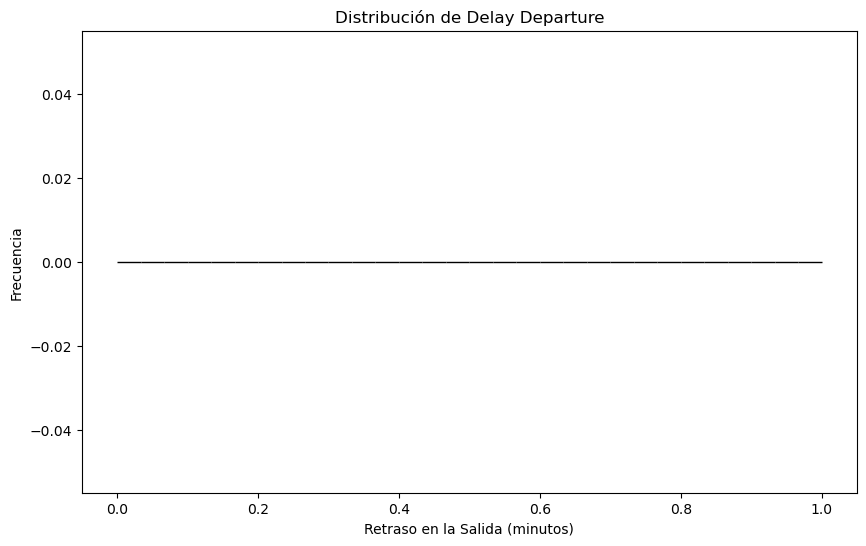

In [19]:
# Crear el gráfico de la distribución
plt.figure(figsize=(10, 6))
sns.histplot(df_nps_tkt['delay_departure'], kde=True, color="skyblue", bins=30)
plt.title('Distribución de Delay Departure')
plt.xlabel('Retraso en la Salida (minutos)')
plt.ylabel('Frecuencia')
plt.show()

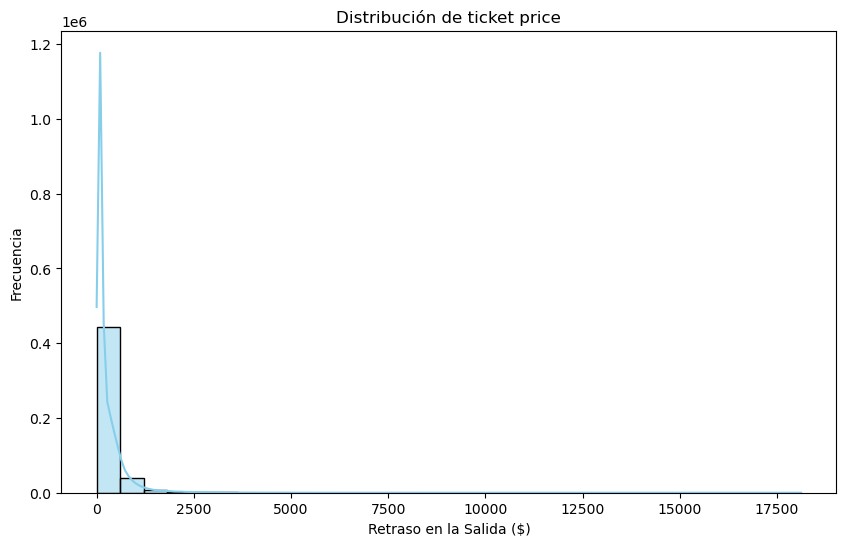

In [20]:
# Crear el gráfico de la distribución
plt.figure(figsize=(10, 6))
sns.histplot(df_nps_tkt['ticket_price'], kde=True, color="skyblue", bins=30)
plt.title('Distribución de ticket price')
plt.xlabel('Retraso en la Salida ($)')
plt.ylabel('Frecuencia')
plt.show()

#### Create otp and load_factor variables


In [21]:
df_nps_tkt['otp15_takeoff'] = (df_nps_tkt['delay'] > 15).astype(int)



In [22]:
df_load_factor.columns

Index(['flight_date_local', 'flight_date_utc', 'operating_carrier',
       'op_flight_num', 'boardpoint_stn_code_actual',
       'offpoint_stn_code_actual', 'haul', 'calc_dep_diff', 'punctuality',
       'capacity_business', 'pax_business', 'capacity_premium_ec',
       'pax_premium_ec', 'capacity_economy', 'pax_economy', 'departure_hour',
       'arrival_hour', 'aircraft_registration_code_actual',
       'flight_date_utc_rescheduled', 'op_carrier_group_ib', 'op_carrier',
       'punctuality_takeoff', 'punctuality2'],
      dtype='object')

In [23]:
df_load_factor.columns

Index(['flight_date_local', 'flight_date_utc', 'operating_carrier',
       'op_flight_num', 'boardpoint_stn_code_actual',
       'offpoint_stn_code_actual', 'haul', 'calc_dep_diff', 'punctuality',
       'capacity_business', 'pax_business', 'capacity_premium_ec',
       'pax_premium_ec', 'capacity_economy', 'pax_economy', 'departure_hour',
       'arrival_hour', 'aircraft_registration_code_actual',
       'flight_date_utc_rescheduled', 'op_carrier_group_ib', 'op_carrier',
       'punctuality_takeoff', 'punctuality2'],
      dtype='object')

In [24]:
# Asumiendo que df_load_factor es tu DataFrame y ya está definido con las columnas relevantes

# Calculando el factor de carga para cada cabina
df_load_factor['load_factor_business'] = df_load_factor['pax_business'] / df_load_factor['capacity_business']
df_load_factor['load_factor_premium_ec'] = df_load_factor['pax_premium_ec'] / df_load_factor['capacity_premium_ec']
df_load_factor['load_factor_economy'] = df_load_factor['pax_economy'] / df_load_factor['capacity_economy']

# Mostrando las nuevas columnas con los factores de carga calculados
df_load_factor[['load_factor_business', 'load_factor_premium_ec', 'load_factor_economy']].head()


,load_factor_business,load_factor_premium_ec,load_factor_economy
0,1.000,NaN,0.994
1,0.167,NaN,0.909
2,1.000,1.000,1.000
3,0.613,0.714,0.765
4,0.579,NaN,0.926


In [25]:
# Asegurarse de que 'flight_date_local' está en formato datetime
df_load_factor['flight_date_local'] = pd.to_datetime(df_load_factor['flight_date_local'])

# Filtrar solo los vuelos de 2023
df_2023 = df_load_factor[df_load_factor['flight_date_local'].dt.year == 2023]

# Extraer mes y año de 'flight_date_local'
df_2023['year_month'] = df_2023['flight_date_local'].dt.to_period('M')

# Agrupar por 'year_month' y 'haul', sumar los pax y capacidad para cada cabina
grouped = df_2023.groupby(['year_month', 'haul']).agg(
    total_pax_business=pd.NamedAgg(column='pax_business', aggfunc='sum'),
    total_capacity_business=pd.NamedAgg(column='capacity_business', aggfunc='sum'),
    total_pax_premium_ec=pd.NamedAgg(column='pax_premium_ec', aggfunc='sum'),
    total_capacity_premium_ec=pd.NamedAgg(column='capacity_premium_ec', aggfunc='sum'),
    total_pax_economy=pd.NamedAgg(column='pax_economy', aggfunc='sum'),
    total_capacity_economy=pd.NamedAgg(column='capacity_economy', aggfunc='sum')
).reset_index()

# Calcular el factor de carga para cada cabina
grouped['load_factor_business'] = grouped['total_pax_business'] / grouped['total_capacity_business']
grouped['load_factor_premium_ec'] = grouped['total_pax_premium_ec'] / grouped['total_capacity_premium_ec']
grouped['load_factor_economy'] = grouped['total_pax_economy'] / grouped['total_capacity_economy']

# Mostrando los resultados
grouped[['year_month', 'haul', 'load_factor_business', 'load_factor_premium_ec', 'load_factor_economy']]



,year_month,haul,load_factor_business,load_factor_premium_ec,load_factor_economy
0,2023-01,LH,0.869,0.819,0.849
1,2023-01,SH,0.587,NaN,0.786
2,2023-02,LH,0.885,0.797,0.866
3,2023-02,SH,0.666,NaN,0.845
4,2023-03,LH,0.912,0.832,0.874
5,2023-03,SH,0.707,NaN,0.856
6,2023-04,LH,0.906,0.849,0.882
7,2023-04,SH,0.666,0.952,0.840
8,2023-05,LH,0.937,0.873,0.872
9,2023-05,SH,0.683,0.979,0.841


In [26]:
df_nps['cabin_in_surveyed_flight'].unique()

array(['Economy', 'Business', 'Premium Economy'], dtype=object)

In [27]:
df_nps['operating_airline_code'].unique()

array(['IB', 'YW', nan], dtype=object)

In [28]:
df_nps_tkt['operating_airline_code']

0          IB
1          IB
2          IB
3          IB
4          IB
           ..
1076891    IB
1076892    IB
1076893    IB
1076894    IB
1076895    IB
Name: operating_airline_code, Length: 829994, dtype: object

In [29]:
# Crear un mapeo basado en el nombre de la cabina hacia la columna de factor de carga en df_load_factor
cabin_to_load_factor_column = {
    'Economy': 'load_factor_economy',
    'Business': 'load_factor_business',
    'Premium Economy': 'load_factor_premium_ec'
}

# Asumiendo que el DataFrame df_nps_tkt ya tiene la columna 'cabin_in_surveyed_flight'

# Paso 3: Realizar una fusión condicional

# Copia el DataFrame original para mantener la integridad de los datos
df_load_factor_renamed = df_load_factor.copy()

# Renombra las columnas manualmente
df_load_factor_renamed.columns = ['date_flight_local' if x=='flight_date_local' else 
                                  'operating_airline_code' if x=='operating_carrier' else
                                  'surveyed_flight_number' if x=='op_flight_num' else
                                  x for x in df_load_factor_renamed.columns]

# Continúa con el proceso de fusión
df_merged = pd.merge(df_nps_tkt, df_load_factor_renamed, 
                     how='left', 
                     on=['date_flight_local', 'operating_airline_code', 'surveyed_flight_number', 'haul'])

# Asigna el factor de carga correcto
df_merged['load_factor'] = df_merged.apply(lambda row: row[cabin_to_load_factor_column[row['cabin_in_surveyed_flight']]], axis=1)

# Resultado
df_final = df_merged[['date_flight_local', 'operating_airline_code', 'surveyed_flight_number', 'haul', 'cabin_in_surveyed_flight', 'load_factor']]



In [30]:
df_merged.columns

Index(['respondent_id', 'sample_id', 'surveyed_flight_number',
       'date_flight_local', 'scheduled_departure_time_local',
       'scheduled_arrival_time_local', 'tier_level', 'language_code',
       'aircraft_registration_number', 'seat_no',
       ...
       'aircraft_registration_code_actual', 'flight_date_utc_rescheduled',
       'op_carrier_group_ib', 'op_carrier', 'punctuality_takeoff',
       'punctuality2', 'load_factor_business', 'load_factor_premium_ec',
       'load_factor_economy', 'load_factor'],
      dtype='object', length=613)

In [31]:
df_nps_tkt = df_merged.copy()

In [32]:
df_nps_tkt['haul'] = df_nps_tkt['haul'].replace('MH', 'SH')

In [33]:
df_nps_tkt[df_nps_tkt['delay']>150][['date_flight_local', 'surveyed_flight_number','delay']]

,date_flight_local,surveyed_flight_number,delay
156,2023-04-27,6454.000,172.000
200,2019-06-08,6400.000,226.000
212,2019-07-27,1331.000,256.000
295,2018-02-05,6845.000,201.000
434,2018-06-13,6827.000,510.000
...,...,...,...
834452,2019-12-20,425.000,152.000
834669,2023-09-11,6123.000,183.000
834672,2023-10-09,6454.000,156.000
834738,2023-10-26,539.000,159.000


#### Create flag promoter and detractor

In [34]:
df_nps_tkt["promoter_binary"] = df_nps_tkt["nps_category"].apply(lambda x: 1 if x == "Promoter" else 0)
df_nps_tkt["detractor_binary"] = df_nps_tkt["nps_category"].apply(lambda x: 1 if x == "Detractor" else 0)
df_nps_tkt["label_multiclass"] = df_nps_tkt["nps_category"].apply(lambda x: 1 if x == "Promoter" else (-1 if x == 'Detractor' else 0))

#### Create some features

In [35]:
def wifi_var(df):

    df["wifi_not_working"] = df["cla_600_wifi_t_f"].apply(lambda x: 1 if x in ["Could not get it to work", "No - I could not get it to work"] else 0)
    df["wifi_used_success"] = df["cla_600_wifi_t_f"].apply(lambda x: 1 if x in ["Yes", "Yes, but not enough"] else 0)
    
    return df

def group_journey_reason(df):
    
    df["tvl_journey_reason"] = df["tvl_journey_reason"].apply(lambda x: 1 if x in ["Business", "Business/work"] else 0)
    
    return df

def feature_covid_indicator(df):
    
    df.loc[df["date_flight_local"] <= "2020-03-13", "indicator_covid"] = 0
    df.loc[df["date_flight_local"] > "2020-03-13", "indicator_covid"] = 1
    
    return df

def group_residence_country(df):
    
    ESP = ["ES"]
    
    EUR = ["AT", "BE", "CH", "DE", "FR", "GB", "UX", "GR", "IL", "IT", "MA", "NL", "PT", "RU", "SE", "CZ", "DZ", 
                 "IE", "SI", "AD", "DK", "FI", "HR", "HU", "LU", "PL", "RO", "SK", "MC", "EE", "NO", "SN"]    
    
    AM_NOR = ["CA", "MX", "PR", "US"]

    LATAM = ["CR", "CU", "DO", "GT", "NI", "PA", "SV", "VE", "HN", "AR", "BR", "CL", "CO", "EC", "PE", "UY", "BO"]
    
    df.loc[df["res100_country_code_survey"].isin(ESP), "country_aggr"] = "ESP"
    df.loc[df["res100_country_code_survey"].isin(EUR), "country_aggr"] = "EUR"
    df.loc[df["res100_country_code_survey"].isin(AM_NOR), "country_aggr"] = "AM_NOR"
    df.loc[df["res100_country_code_survey"].isin(LATAM), "country_aggr"] = "LATAM"
    
    df["country_aggr"] = df["country_aggr"].fillna("Others")
    return df


def group_residence_country_custom(df):
    
    regions = {'EUROPA': ['Albania', 'AL','Andorra','AD','Armenia','AM','Austria','AT','Azerbaijan','Belarus','BY','Belgium','BE','Bosnia and Herzegovina','BA','Bulgaria','BG','Croatia','HR',
      'Cyprus','CY','Czech Republic','CZ','Denmark','DK','Estonia','EE','Faeroe Islands','FO','Finland','FI','France','FR','Georgia','GE','Germany','DE','Gibraltar','GI','Greece','GR','Greenland',
      'GL','Hungary','HU','Iceland','IS','Ireland','IE','Italy','IT','Latvia','LV','Lebanon','LB','Liechtenstein','LI','Lithuania','LT','Luxembourg','LU','Malta','MT','Moldova','MD','Monaco',
      'ME','Netherlands','NL','MK','Northern Ireland','Norway','NO','Poland','PL','Portugal','PT','MC','Romania','RO','Russia','RU','San Marino','SM','RS','Slovakia','SK','Slovenia','SI','Sweden',
      'SE','Switzerland','CH','Turkey','TR','UK (excl NI)','Ukraine','UA','GB','Vatican City','Yugoslavia'],
     'AFRICA': ['Algeria','DZ','Angola','AO','Botswana','Burkina Faso','BF','Burundi','Cameroon','CM','Cape Verde','CV','Central African Republic','Comoros','Congo',"Côte d'Ivoire",'Djibouti','DJ',
      'Egypt','EG','Equatorial Guinea','GQ','Eritrea','ER','SZ','Ethiopia','ET','French Southern Territories','Gabon','GA','GM','Ghana','GH','Guinea','Guinea-Bissau','GW','CI','Jordan','JO','Kenya',
      'KE','Liberia','LR','Libya','LY','Macedonia','Madagascar','MG','Malawi','MW','Mali','ML','Mauritania','MR','Mauritius','MU','Mayotte','YT','Morocco','MA','Mozambique','MZ','Namibia','Niger',
      'Nigeria','NG','CG','RE','Réunion','Rwanda','São Tomé and Príncipe','Senegal','SN','Seychelles','SC','Sierra Leone','SO','South Africa','ZA','SD','Sudan','Swaziland','Tanzania','TZ','The Gambia',
      'Togo','Trinidad and Tobago','TT','Tunisia','TN','Uganda','UG','Western Sahara''Zambia','Zimbabwe','ZW','Somalia','Benin'],
     'ASIA': ['Afghanistan','AF','Australia','AU','Bangladesh','Bhutan','BN','Cambodia','KH','China','CN','Cocos (Keeling) Islands','Cook Islands','East Timor','Fiji','FJ','French Polynesia','PF',
      'GU','Hong Kong','HK','India','IN','Indonesia','ID','Japan','JP','MO','Macau','Malaysia','MY','Maldives','MV','Micronesia','MN','Myanmar','MM','Nepal','NP','New Caledonia','NC','New Zealand',
      'NZ','Northern Marianas','Papua New Guinea','PG','Philippines','PH','Singapore','SG','Solomon Islands','South Korea','KR','Sri Lanka','LK','Taiwan','TW','Tajikistan','Thailand','TH','Turkmenistan',
      'TM','Uzbekistan','UZ','VU','Vanuatu','Vietnam','VN','Wallis and Futuna','Brunei','Guam'],
     'AMERICA CENTRO': ['American Samoa','Anguilla','Antigua and Barbuda','Aruba','AW','BS','Barbados','Belize','BZ','British Virgin Islands','VG','Cayman Islands','KY','Colombia','CO','Costa Rica','CR',
      'Cuba','CU','Dominica','DM','Dominican Republic','DO','El Salvador','SV','Falkland Islands','FK','Grenada','GD','Guadeloupe','GP','Guatemala','GT','Haiti','HT','Honduras','HN','Jamaica','JM',
      'Martinique','MQ','Mexico','MX','Montserrat','MS','Netherlands Antilles','Panama','PA','Puerto Rico','PR','Saint Helena','KN','Saint Lucia','Saint Vincent and the Grenadines','The Bahamas',
      'Turks and Caicos Islands','TC','US Virgin Islands','VI','Saint Kitts and Nevis'],
     'AMERICA SUR': ['Argentina','AR','Bolivia','BO','Brazil','BR','Chile','CL','Ecuador','EC','French Guiana','GF','Guyana','GY','Nicaragua','NI','Paraguay','PY','Peru','PE','Suriname','Uruguay','UY',
      'Venezuela','VE'],
     'ORIENTE MEDIO': ['Bahrain','BH','Bermuda','BM','Iran','IR','Iraq','IQ','Israel','IL','Kazakhstan','KZ','Kuwait','KW','Kyrgyzstan','KG','Oman','OM','Pakistan','PK','Qatar','QA','Saudi Arabia',
      'SA','Syria','United Arab Emirates','AE','Yemen'],
     'AMERICA NORTE': ['Canada', 'CA', 'United States', 'US'],
     'ESPAÑA': ['Spain', 'ES']}
    
    # Defining regions with corresponding country codes directly within the function
    EUROPA = regions["EUROPA"]
    AFRICA = regions["AFRICA"]
    ASIA = regions["ASIA"]
    AMERICA_CENTRO = regions["AMERICA CENTRO"]
    AMERICA_SUR = regions["AMERICA SUR"]
    ORIENTE_MEDIO = regions["ORIENTE MEDIO"]
    AMERICA_NORTE = regions["AMERICA NORTE"]
    ESPAÑA = regions["ESPAÑA"]
    
    # Assigning regions to 'country_aggr' based on the country codes
    df.loc[df["res100_country_code_survey"].isin(ESPAÑA), "country_aggr"] = "ESPAÑA"
    df.loc[df["res100_country_code_survey"].isin(EUROPA), "country_aggr"] = "EUROPA"
    df.loc[df["res100_country_code_survey"].isin(AFRICA), "country_aggr"] = "AFRICA"
    df.loc[df["res100_country_code_survey"].isin(ASIA), "country_aggr"] = "ASIA"
    df.loc[df["res100_country_code_survey"].isin(AMERICA_CENTRO), "country_aggr"] = "AMERICA CENTRO"
    df.loc[df["res100_country_code_survey"].isin(AMERICA_SUR), "country_aggr"] = "AMERICA SUR"
    df.loc[df["res100_country_code_survey"].isin(ORIENTE_MEDIO), "country_aggr"] = "ORIENTE MEDIO"
    df.loc[df["res100_country_code_survey"].isin(AMERICA_NORTE), "country_aggr"] = "AMERICA NORTE"
    
    # Defaulting to 'Others' for countries not listed
    df["country_aggr"] = df["country_aggr"].fillna("Others")
    
    return df

def issues_binary(df, dict_touchpoints):
    all_unique_issues = [i for i in dict_touchpoints["issue_type_2"].unique()]
    for issue in all_unique_issues:
        df[issue] = df[issue].apply(lambda x: 0 if pd.isna(x) else 1)

    for touchpoint in dict_touchpoints["associated_touchpoint"].unique():
        related_issues = [i for i in dict_touchpoints.loc[dict_touchpoints["associated_touchpoint"] == touchpoint]["issue_type_2"]]
        new_feature = "issues_{}".format(touchpoint)
        df[new_feature] = df[related_issues].sum(axis = 1)
        df[new_feature] = df[new_feature].apply(lambda x: 1 if x >= 1 else 0)
    return df

In [36]:
df_nps_tkt = wifi_var(df_nps_tkt)
df_nps_tkt = group_journey_reason(df_nps_tkt)
df_nps_tkt = feature_covid_indicator(df_nps_tkt)
df_nps_tkt = group_residence_country_custom(df_nps_tkt)
# df_nps_tkt = issues_binary(df_nps_tkt, df_touchpoints)

In [37]:
df_nps_tkt[['cabin_in_surveyed_flight', 'haul', 'otp15_takeoff','pun_100_punctuality']]

,cabin_in_surveyed_flight,haul,otp15_takeoff,pun_100_punctuality
0,Economy,SH,0,9.000
1,Economy,SH,0,7.000
2,Economy,SH,0,9.000
3,Economy,SH,0,3.000
4,Economy,LH,1,2.000
...,...,...,...,...
835027,Economy,SH,0,9.000
835028,Economy,SH,0,9.000
835029,Economy,SH,0,10.000
835030,Economy,LH,0,10.000


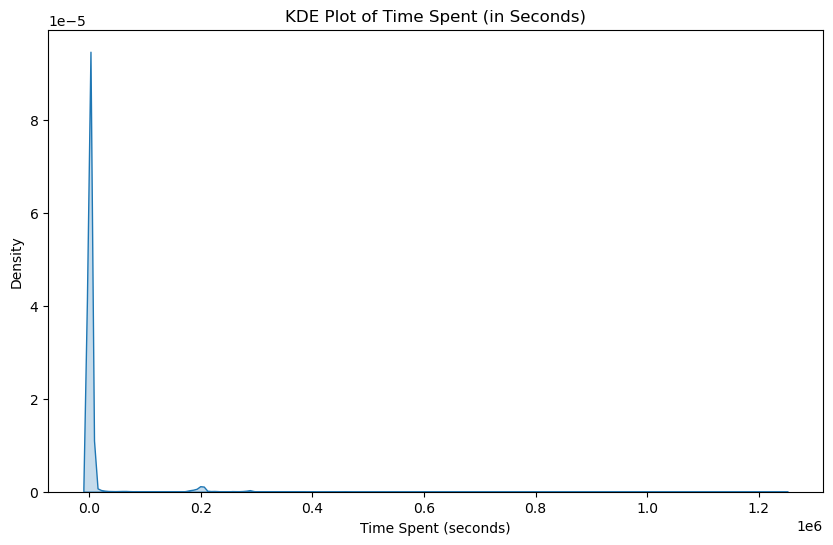

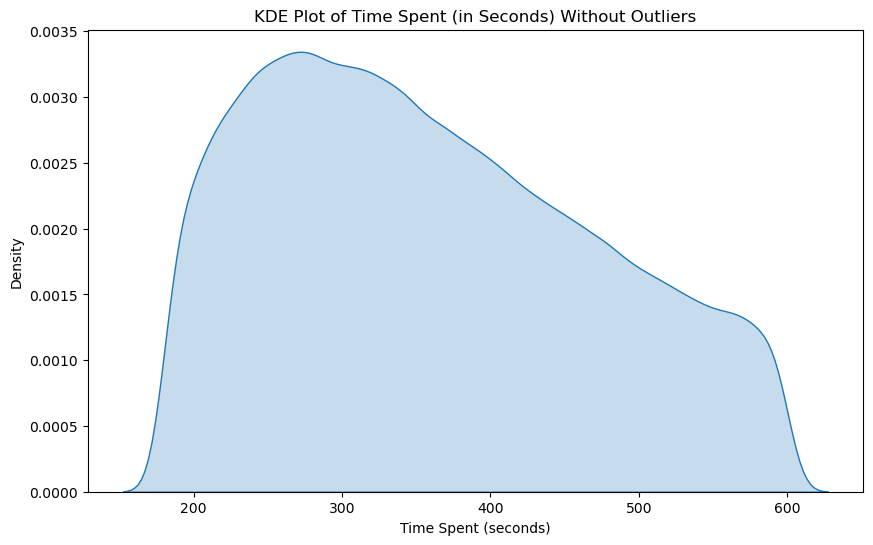

In [38]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
# time_spent_hrminsec= df_nps_tkt[df_nps_tkt['date_flight_local']>='2023-01-01']['delay']
time_spent_hrminsec= df_nps_tkt[df_nps_tkt['date_flight_local']>='2023-01-01']['time_spent_hrminsec']
# Identify and remove outliers
Q1 = time_spent_hrminsec.quantile(0.05)
Q3 = time_spent_hrminsec.quantile(0.95)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
# Filter out the outliers
filtered_time_spent = time_spent_hrminsec[(time_spent_hrminsec >= 180) & (time_spent_hrminsec <= 600)]
# filtered_time_spent = time_spent_hrminsec[(time_spent_hrminsec <= 50) & (time_spent_hrminsec >= -50)]

# Generate the KDE plot without outliers
plt.figure(figsize=(10, 6))
sns.kdeplot(time_spent_hrminsec, shade=True)

# Add titles and labels
plt.title('KDE Plot of Time Spent (in Seconds)')
plt.xlabel('Time Spent (seconds)')
plt.ylabel('Density')

# Display the plot
plt.show()

# Generate the KDE plot without outliers
plt.figure(figsize=(10, 6))
sns.kdeplot(filtered_time_spent, shade=True)

# Add titles and labels
plt.title('KDE Plot of Time Spent (in Seconds) Without Outliers')
plt.xlabel('Time Spent (seconds)')
plt.ylabel('Density')

# Display the plot
plt.show()


In [39]:
# df_nps_tkt = df_nps_tkt[(df_nps_tkt['time_spent_hrminsec']<600) & (df_nps_tkt['time_spent_hrminsec']>180)]

#### Select column

In [40]:
df_nps_tkt[['country_aggr']]

,country_aggr
0,EUROPA
1,AMERICA NORTE
2,ESPAÑA
3,ESPAÑA
4,EUROPA
...,...
835027,AMERICA SUR
835028,ESPAÑA
835029,ESPAÑA
835030,AMERICA CENTRO


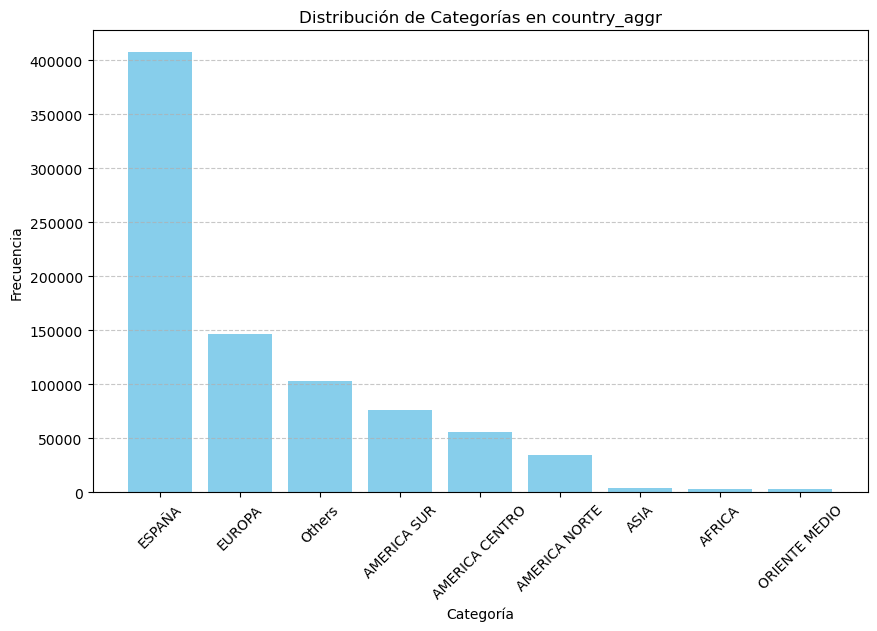

In [41]:
# Contamos las ocurrencias de cada categoría
category_counts = df_nps_tkt['country_aggr'].value_counts()

# Creamos el histograma
plt.figure(figsize=(10, 6))  # Tamaño del gráfico para mayor claridad
plt.bar(category_counts.index, category_counts.values, color='skyblue')  # Bar plot
plt.title('Distribución de Categorías en country_aggr')  # Título del gráfico
plt.xlabel('Categoría')  # Etiqueta para el eje X
plt.ylabel('Frecuencia')  # Etiqueta para el eje Y
plt.xticks(rotation=45)  # Rotamos las etiquetas del eje X para mejor legibilidad
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Agregamos una cuadrícula en el eje Y para referencia
plt.show()


In [42]:
# Crear una nueva columna 'eng_pun_100_punctuality' basada en la condición de 'otp15_takeoff'
df_nps_tkt['eng_punctuality'] = np.where(
    df_nps_tkt['otp15_takeoff'] == 1,
    df_nps_tkt['pun_100_punctuality'] / 2,
    df_nps_tkt['pun_100_punctuality']
)


In [43]:
columns_to_select = ['respondent_id','cabin_in_surveyed_flight', 'haul','date_flight_local'] + touchpoints + ['nps_100','eng_punctuality','otp15_takeoff', 'delay', 'delay_departure','ticket_price','load_factor','country_aggr'] + labels + labels_multi
# + [col for col in df_nps_tkt_select.columns if 'issues_' in col]
df_nps_tkt_selected = df_nps_tkt[columns_to_select]

In [44]:
# One-hot encoding
# df_nps_tkt_selected = pd.get_dummies(df_nps_tkt_selected, columns=['country_aggr'])

In [45]:
# Target encoding
# Calcula el promedio de la variable objetivo para cada categoría en 'country_aggr'
mean_target_per_category = df_nps_tkt_selected.groupby('country_aggr')['promoter_binary'].mean() - df_nps_tkt_selected.groupby('country_aggr')['detractor_binary'].mean()

# Mapea estos promedios a tu columna categórica original
df_nps_tkt_selected['country_aggr'] = df_nps_tkt_selected['country_aggr'].map(mean_target_per_category)

# Ahora 'country_aggr_encoded' contiene los valores de target encoding para la columna 'country_aggr'


In [46]:
mean_target_per_category

country_aggr
AFRICA           0.212
AMERICA CENTRO   0.469
AMERICA NORTE    0.161
AMERICA SUR      0.334
ASIA             0.065
ESPAÑA           0.343
EUROPA           0.221
ORIENTE MEDIO    0.105
Others           0.285
dtype: float64

In [47]:
df_nps_tkt_selected['country_aggr']

0        0.221
1        0.161
2        0.343
3        0.343
4        0.221
          ... 
835027   0.334
835028   0.343
835029   0.343
835030   0.469
835031   0.343
Name: country_aggr, Length: 835032, dtype: float64

### Input ticket_price

In [48]:
df_nps_tkt = df_nps_tkt_selected.copy()

In [49]:
features_dummy = ['ticket_price', 'load_factor']+['pun_100_punctuality','bkg_200_journey_preparation', 'pfl_100_checkin', 
                  'pfl_200_security', 'pfl_300_lounge', 'pfl_500_boarding', 'ifl_300_cabin', 
                  'ifl_200_flight_crew_annoucements', 'ifl_600_wifi', 'ifl_500_ife', 'ifl_400_food_drink', 
                  'ifl_100_cabin_crew', 'arr_100_arrivals', 'con_100_connections', 
                  'loy_200_loyalty_programme', 'img_310_ease_contact_phone']

# features_dummy = ['delay','ticket_price','load_factor']
labels = ['promoter_binary', 'detractor_binary']

df_nps_tkt = df_nps_tkt[['respondent_id', 'cabin_in_surveyed_flight', 'haul', 'date_flight_local', 'nps_100']+features_dummy+labels]

In [50]:
# Ensure date_flight_local is a datetime type if not already
df_nps_tkt['date_flight_local'] = pd.to_datetime(df_nps_tkt['date_flight_local'])

# Extract month and year from date_flight_local and create new columns
df_nps_tkt['month'] = df_nps_tkt['date_flight_local'].dt.month
df_nps_tkt['year'] = df_nps_tkt['date_flight_local'].dt.year


In [51]:
df_nps_tkt['date_flight_local'].min()

Timestamp('2017-01-09 00:00:00')

0         2017
1         2017
2         2017
3         2017
4         2017
          ... 
835027    2024
835028    2024
835029    2024
835030    2024
835031    2024
Name: year, Length: 835032, dtype: int32


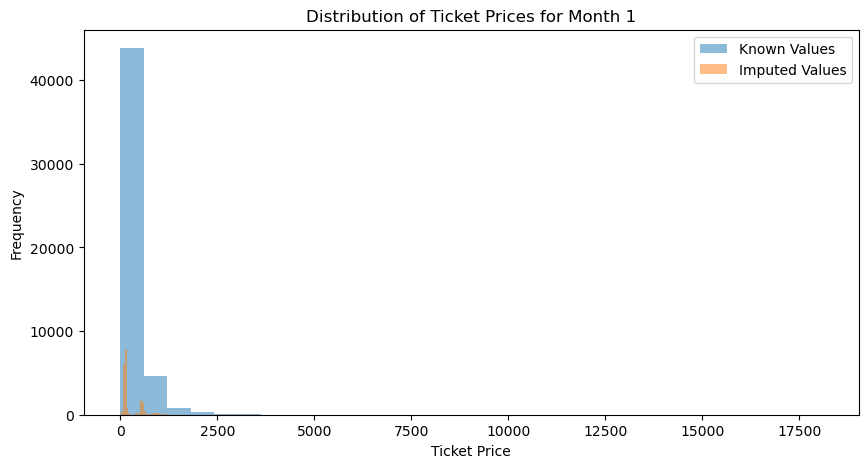

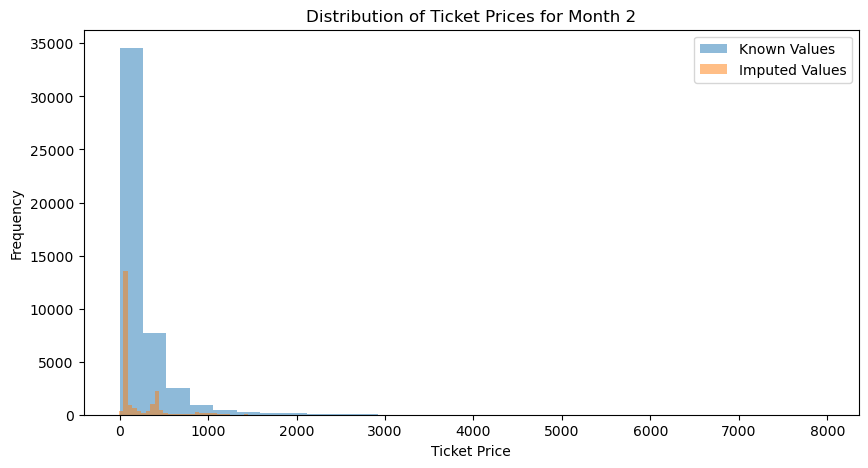

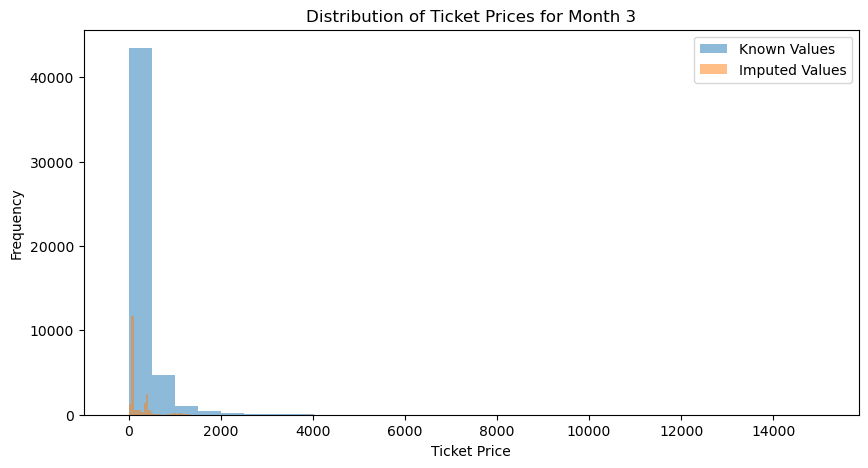

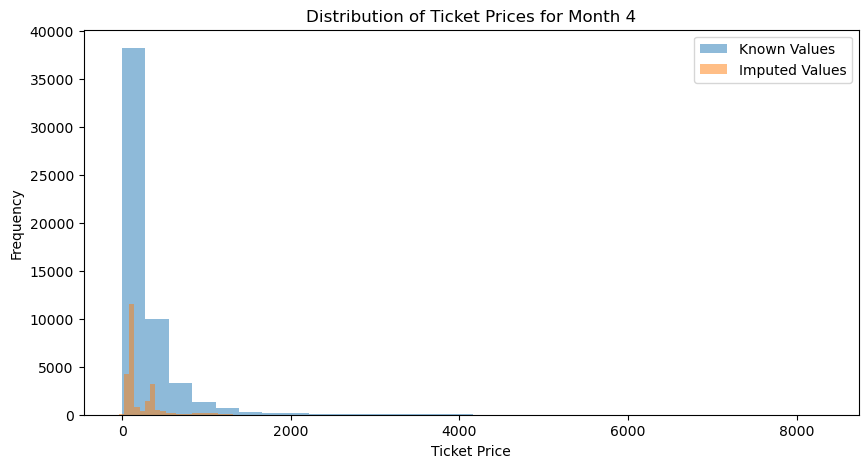

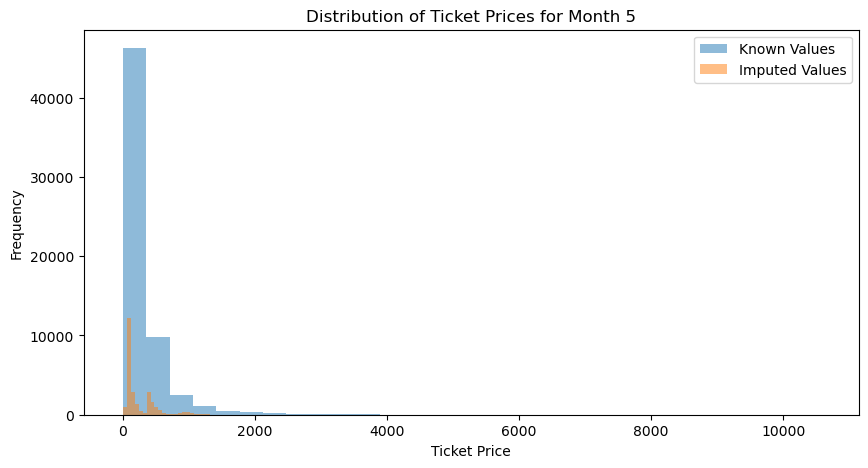

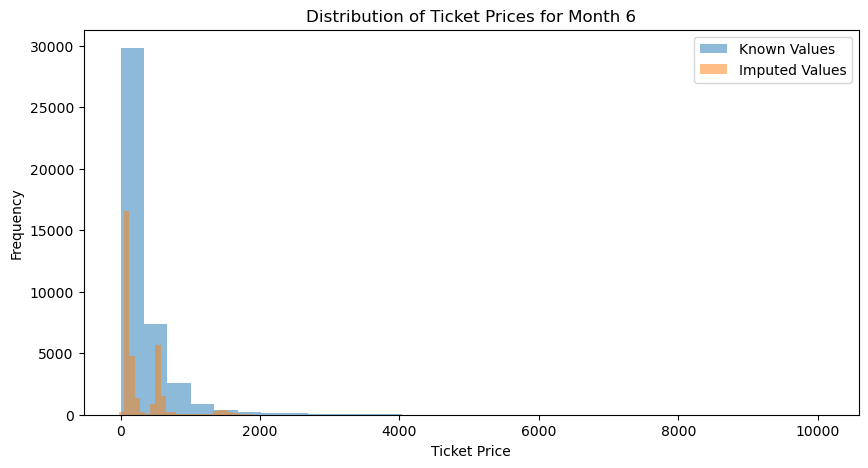

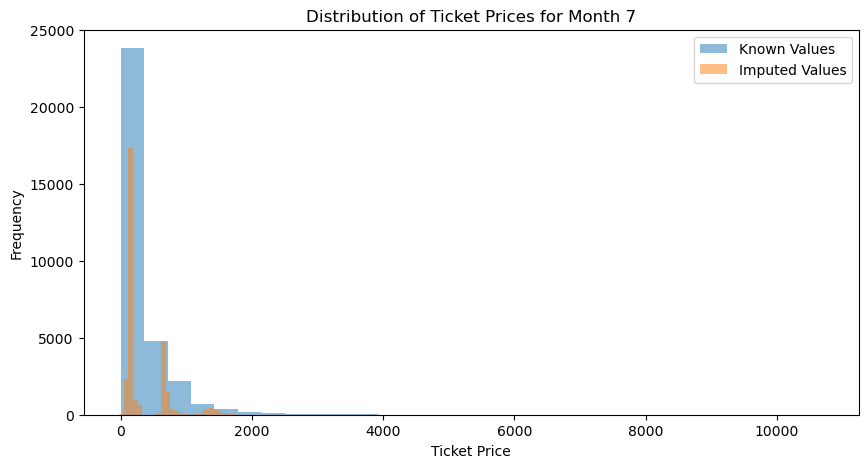

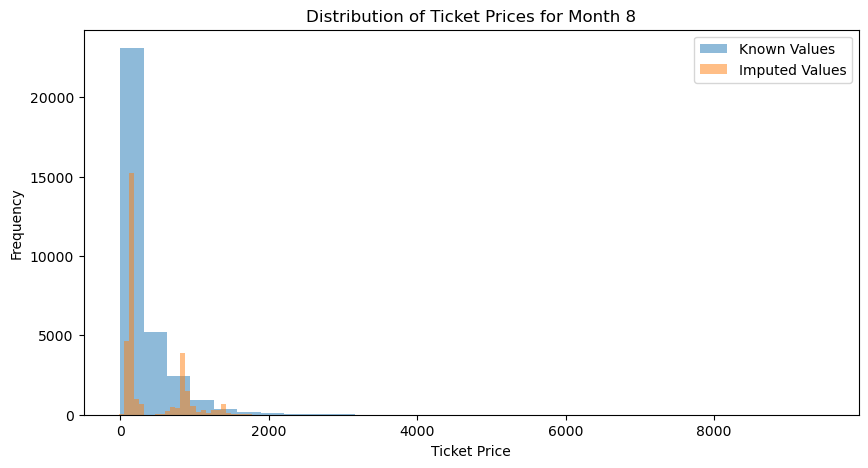

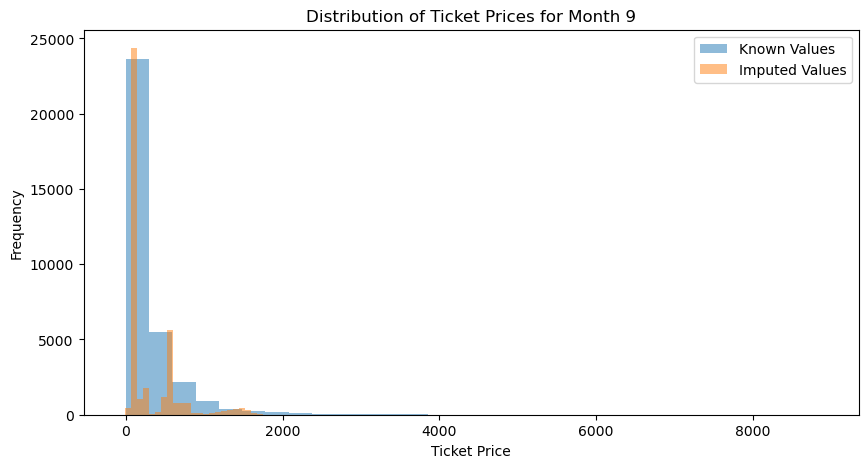

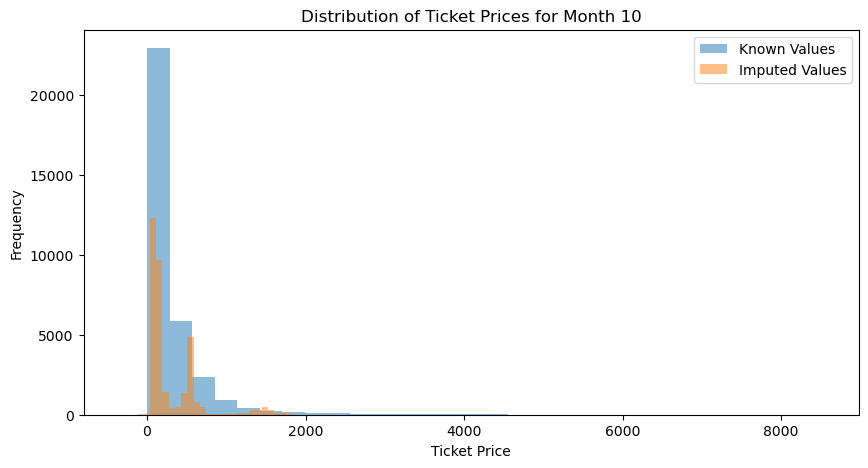

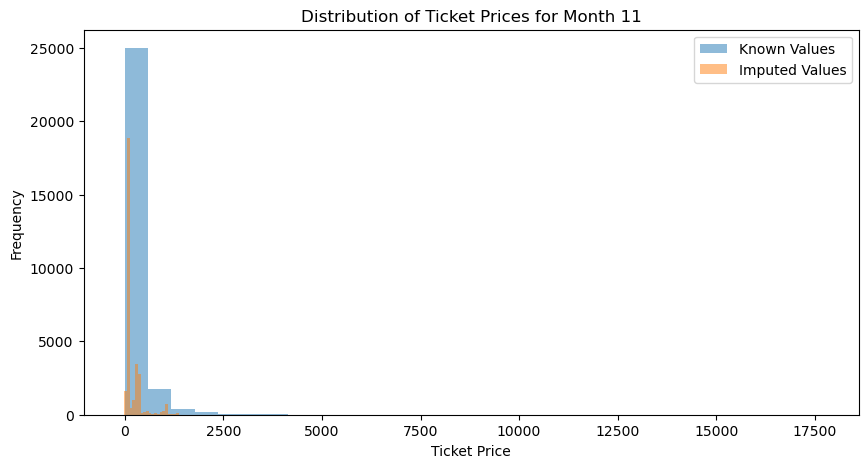

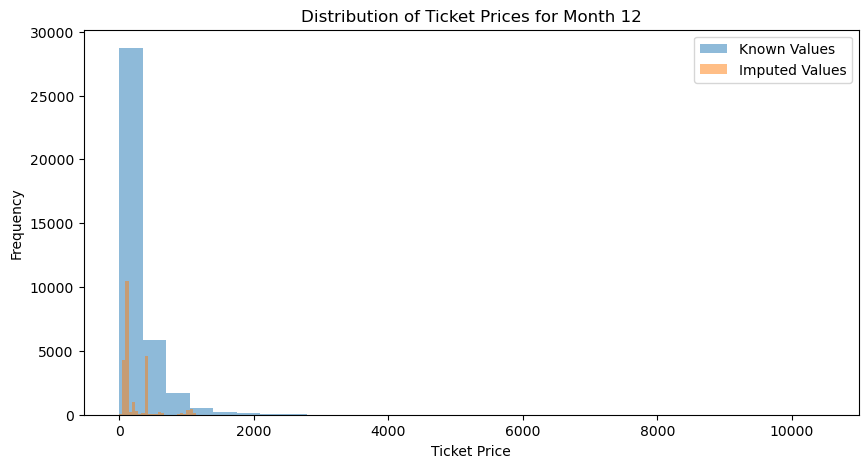

In [52]:
# Assuming df_nps_tkt is your DataFrame and it's already loaded
# Convert 'date_flight_local' to datetime and extract 'month' and 'year' if not already done
df_nps_tkt['date_flight_local'] = pd.to_datetime(df_nps_tkt['date_flight_local'])
df_nps_tkt['month'] = df_nps_tkt['date_flight_local'].dt.month
df_nps_tkt['year'] = df_nps_tkt['date_flight_local'].dt.year
print(df_nps_tkt['year'])
# Identify categorical and numerical columns; make sure 'month' and 'year' are not in these lists
categorical_features = df_nps_tkt.select_dtypes(include=['object', 'bool']).columns.tolist()
numerical_features = df_nps_tkt.select_dtypes(include=['int32', 'int64', 'float64']).columns.drop(['ticket_price', 'month', 'year']).tolist()

# Define the preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', SimpleImputer(strategy='median'), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
    ]
)

# Define the model pipeline
pipeline = make_pipeline(
    preprocessor,
    GradientBoostingRegressor(random_state=42)
)

# Loop over each month to train a model and impute missing values
for month in sorted(df_nps_tkt['month'].unique()):
    # Filter the data for the specific month
    df_month = df_nps_tkt[df_nps_tkt['month'] == month]
    
    # Split data into features and target
    X = df_month.drop(columns=['ticket_price', 'date_flight_local', 'month', 'year'])
    y = df_month['ticket_price']
    
    # Further split your data into training and missing data (for imputation)
    X_train = X.loc[y.notna()]
    y_train = y.loc[y.notna()]
    
    if len(X_train) > 0:
        # Train the model
        pipeline.fit(X_train, y_train)
        
        # Identify indices where ticket_price is NaN for imputation
        idx_missing = y[y.isna()].index
        
        # Predict missing ticket_price values
        X_missing = X.loc[idx_missing]
        if len(X_missing) > 0:
            imputed_values = pipeline.predict(X_missing)
            
            # Fill in the missing values in the original DataFrame
            df_nps_tkt.loc[idx_missing, 'ticket_price'] = imputed_values

            # Verification: Distribution comparison
            plt.figure(figsize=(10, 5))
            plt.hist(y_train, bins=30, alpha=0.5, label='Known Values')
            plt.hist(imputed_values, bins=30, alpha=0.5, label='Imputed Values')
            plt.title(f'Distribution of Ticket Prices for Month {month}')
            plt.xlabel('Ticket Price')
            plt.ylabel('Frequency')
            plt.legend()
            plt.show()


# Training

In [53]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, log_loss

def calculate_classification_scores(y_true, y_pred, y_prob):
    """ Use classification measures to evaluate the model."""
    
    sample_size = len(y_true)
    pct_target = sum(y_true) / sample_size
    pct_pred = sum(y_pred) / sample_size
    cm = confusion_matrix(y_true, y_pred)
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)

    # Manejo especial para log_loss cuando y_true contiene solo una clase
    if len(set(y_true)) > 1:
        loss = log_loss(y_true, y_prob)
    else:
        loss = None  # O manejar de otra manera que tenga sentido para tu análisis
    
    score_dict = {
        "sample size": sample_size,
        "len_y_pred": len(y_pred),
        "len_y_prob": len(y_prob),
        "pct_target": pct_target, 
        "pct_pred": pct_pred,
        "confusion_matrix": cm, 
        "accuracy": accuracy, 
        "precision": precision, 
        "recall": recall, 
        "f1": f1,
        "log_loss": loss
    }
    
    return score_dict


from sklearn.model_selection import train_test_split, KFold
from catboost import CatBoostClassifier, Pool
import pandas as pd

def train_test_predict_cv_ctb(df, features, labels, n_splits=5):
    result_dict = {}
    result_dict_ch = {}
    
    # Convertir 'date_flight_local' a datetime si no lo es
    df['date_flight_local'] = pd.to_datetime(df['date_flight_local'])
    
    # Si labels es una sola etiqueta, conviértela en una lista para un manejo uniforme
    labels = [labels] if isinstance(labels, str) else labels

    # Construyendo la lista de todas las columnas necesarias
    all_features = features + ['cabin_in_surveyed_flight', 'haul', 'date_flight_local', 'nps_100'] + labels

    # Dividiendo el dataset
    train_df, test_df = train_test_split(
        df,
        stratify=df["date_flight_local"].dt.year,
        test_size=0.2,
        random_state=1
    )
    
    test_df=df[(df['date_flight_local'].dt.year==2024) & (df['date_flight_local'].dt.month==1)] # Para comprobar metricas d eun mes particular

    # Preparación para validación cruzada y entrenamiento del modelo
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=1)
    # cat_features = ['otp15_takeoff']  # Ajusta según tus características categóricas
    cat_features = []
    
    for target_label in labels:
        # Create a dictionary to set feature weights
        # feature_weights = {feature: 10.0 if feature == 'otp15_takeoff' else 1.0 for feature in features}
        feature_weights = {}
        clf = CatBoostClassifier(cat_features=cat_features, feature_weights = feature_weights,  random_seed=0, verbose=0)
        
        cv_scores = []
        for train_index, val_index in kf.split(train_df):
            # Aquí seleccionamos solo las columnas de características para el entrenamiento
            X_train_fold = train_df.iloc[train_index][features]
            X_val_fold = train_df.iloc[val_index][features]
            y_train_fold = train_df.iloc[train_index][target_label]
            y_val_fold = train_df.iloc[val_index][target_label]

            train_pool = Pool(X_train_fold, y_train_fold, cat_features=cat_features)
            val_pool = Pool(X_val_fold, y_val_fold, cat_features=cat_features)

            clf.fit(train_pool, eval_set=val_pool, early_stopping_rounds=10, verbose=False)
            cv_scores.append(clf.get_best_score())

        # Realizar predicciones y calcular métricas para los conjuntos completos
        train_pred = clf.predict(train_df[features])
        train_pred_prob = clf.predict_proba(train_df[features])
        test_pred = clf.predict(test_df[features])
        test_pred_prob = clf.predict_proba(test_df[features])

        train_metrics = calculate_classification_scores(train_df[target_label], train_pred, train_pred_prob)
        test_metrics = calculate_classification_scores(test_df[target_label], test_pred, test_pred_prob)

        result_dict[target_label] = {
            "cv_scores": cv_scores,
            "train": {"model": clf, "y_true": train_df[target_label], "y_pred": train_pred, "y_prob": train_pred_prob, "metrics": train_metrics},
            "test": {"model": clf, "y_true": test_df[target_label], "y_pred": test_pred, "y_prob": test_pred_prob, "metrics": test_metrics}
        }

        # Encuentra todas las combinaciones únicas de 'cabin_in_surveyed_flight' y 'haul'
        combinations = df[['cabin_in_surveyed_flight', 'haul']].drop_duplicates()

        for index, row in combinations.iterrows():
            cabin = row['cabin_in_surveyed_flight']
            haul = row['haul']
            cabin_haul_key = f"{cabin}_{haul}"  # Clave única para cada combinación

            # Filtrar train_df y test_df por cabin y haul
            train_ch_df = train_df[(train_df['cabin_in_surveyed_flight'] == cabin) & (train_df['haul'] == haul)]
            test_ch_df = test_df[(test_df['cabin_in_surveyed_flight'] == cabin) & (test_df['haul'] == haul)]

            if not train_ch_df.empty and not test_ch_df.empty:
                    train_pred_ch = clf.predict(train_ch_df[features])
                    train_pred_prob_ch = clf.predict_proba(train_ch_df[features])
                    test_pred_ch = clf.predict(test_ch_df[features])
                    test_pred_prob_ch = clf.predict_proba(test_ch_df[features])

                    train_metrics_ch = calculate_classification_scores(train_ch_df[target_label], train_pred_ch, train_pred_prob_ch)
                    test_metrics_ch = calculate_classification_scores(test_ch_df[target_label], test_pred_ch, test_pred_prob_ch)

                    result_dict_ch[target_label] = result_dict_ch.get(target_label, {})
                    result_dict_ch[target_label][cabin_haul_key] = {
                        "train": {"y_true": train_ch_df[target_label], "y_pred": train_pred_ch, "y_prob": train_pred_prob_ch, "metrics": train_metrics_ch},
                        "test": {"y_true": test_ch_df[target_label], "y_pred": test_pred_ch, "y_prob": test_pred_prob_ch, "metrics": test_metrics_ch}
                    }
    
    return result_dict, result_dict_ch



from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, log_loss
from sklearn.impute import SimpleImputer

def calculate_classification_scores(y_true, y_pred, y_prob):
    return {
        "classification_report": classification_report(y_true, y_pred, output_dict=True),
        "roc_auc_score": roc_auc_score(y_true, y_prob[:, 1]),
        "log_loss": log_loss(y_true, y_prob)
    }




def train_models(df, features, labels, start_date, end_date, n_splits=10):
    """
    Entrena modelos para predecir promotores y detractores dentro de un rango de fechas.

    Args:
    - df: DataFrame con los datos.
    - features: Lista de características a usar.
    - labels: Lista de etiquetas a predecir.
    - start_date: Fecha de inicio para los datos de entrenamiento.
    - end_date: Fecha de fin para los datos de entrenamiento.
    - n_splits: Número de divisiones para validación cruzada.

    Returns:
    - Un diccionario con los modelos entrenados, los conjuntos de datos de entrenamiento y prueba.
    """
    # Filtrar el DataFrame por el rango de fechas
    df_filtered = df[(df['date_flight_local'] >= start_date) & (df['date_flight_local'] < end_date)]
    
    # Llamada a la función existente para entrenar y evaluar modelos
    result_dict, result_dict_ch = train_test_predict_cv_ctb(df_filtered, features, labels, n_splits)
    
    # Guardar modelos
    models = {label: result_dict[label]['train']['model'] for label in labels}
    
    # Guardar métricas
    metrics_train = {label: result_dict[label]['train']['metrics'] for label in labels}
    metrics_test = {label: result_dict[label]['test']['metrics'] for label in labels}
    
    # Guardar conjuntos de entrenamiento y prueba
    # train_set = result_dict["train_set"]
    # test_set = result_dict["test_set"]
    
    return {"models": models, "metrics_train": metrics_train, "metrics_test": metrics_test}, result_dict_ch

In [54]:
df_nps_tkt.to_csv('historic_with_interactions.csv')

In [55]:
df_nps_tkt.columns

Index(['respondent_id', 'cabin_in_surveyed_flight', 'haul',
       'date_flight_local', 'nps_100', 'ticket_price', 'load_factor',
       'pun_100_punctuality', 'bkg_200_journey_preparation', 'pfl_100_checkin',
       'pfl_200_security', 'pfl_300_lounge', 'pfl_500_boarding',
       'ifl_300_cabin', 'ifl_200_flight_crew_annoucements', 'ifl_600_wifi',
       'ifl_500_ife', 'ifl_400_food_drink', 'ifl_100_cabin_crew',
       'arr_100_arrivals', 'con_100_connections', 'loy_200_loyalty_programme',
       'img_310_ease_contact_phone', 'promoter_binary', 'detractor_binary',
       'month', 'year'],
      dtype='object')

In [56]:
# Asume que df_nps_tkt_select es tu DataFrame y ya ha sido cargado correctamente
train_results, cabin_haul_results = train_models(df=df_nps_tkt, 
                             features=features_dummy, 
                             labels=labels, 
                             start_date='2023-01-01', 
                             end_date='2024-07-01', 
                             n_splits=20)

In [57]:
train_results['metrics_train']

{'promoter_binary': {'classification_report': {'0': {'precision': 0.8584474541505791,
    'recall': 0.8118514609289754,
    'f1-score': 0.8344995180095811,
    'support': 140219.0},
   '1': {'precision': 0.8635143174939859,
    'recall': 0.8989088989896814,
    'f1-score': 0.8808561951981508,
    'support': 185684.0},
   'accuracy': 0.8614526408164392,
   'macro avg': {'precision': 0.8609808858222825,
    'recall': 0.8553801799593284,
    'f1-score': 0.857677856603866,
    'support': 325903.0},
   'weighted avg': {'precision': 0.8613343114457165,
    'recall': 0.8614526408164392,
    'f1-score': 0.8609113437585996,
    'support': 325903.0}},
  'roc_auc_score': 0.935454761102293,
  'log_loss': 0.3166869266953027},
 'detractor_binary': {'classification_report': {'0': {'precision': 0.933696147598141,
    'recall': 0.9599444083980166,
    'f1-score': 0.9466383608985436,
    'support': 249678.0},
   '1': {'precision': 0.8554894084327949,
    'recall': 0.7767136766152837,
    'f1-score': 0.8

In [58]:
train_results['metrics_test']

{'promoter_binary': {'classification_report': {'0': {'precision': 0.8547713280562885,
    'recall': 0.8036175710594315,
    'f1-score': 0.8284055191518832,
    'support': 9675.0},
   '1': {'precision': 0.8635449583453031,
    'recall': 0.9010116148370176,
    'f1-score': 0.8818805236715684,
    'support': 13345.0},
   'accuracy': 0.8600781928757603,
   'macro avg': {'precision': 0.8591581432007958,
    'recall': 0.8523145929482245,
    'f1-score': 0.8551430214117258,
    'support': 23020.0},
   'weighted avg': {'precision': 0.8598575181608453,
    'recall': 0.8600781928757603,
    'f1-score': 0.8594056901038901,
    'support': 23020.0}},
  'roc_auc_score': 0.935395761267031,
  'log_loss': 0.31564567618294703},
 'detractor_binary': {'classification_report': {'0': {'precision': 0.9330076004343105,
    'recall': 0.9641514726507714,
    'f1-score': 0.9483239067457581,
    'support': 17825.0},
   '1': {'precision': 0.8610869565217392,
    'recall': 0.7624639076034648,
    'f1-score': 0.8087

In [59]:
cabin_haul_results['detractor_binary']['Business_LH']['test']['metrics']

{'classification_report': {'0': {'precision': 0.9282920469361148,
   'recall': 0.956989247311828,
   'f1-score': 0.9424222369291859,
   'support': 744.0},
  '1': {'precision': 0.8,
   'recall': 0.6994535519125683,
   'f1-score': 0.7463556851311953,
   'support': 183.0},
  'accuracy': 0.9061488673139159,
  'macro avg': {'precision': 0.8641460234680574,
   'recall': 0.8282213996121981,
   'f1-score': 0.8443889610301907,
   'support': 927.0},
  'weighted avg': {'precision': 0.9029657852432248,
   'recall': 0.9061488673139159,
   'f1-score': 0.9037165422376732,
   'support': 927.0}},
 'roc_auc_score': 0.9414110699806099,
 'log_loss': 0.22616284297698525}

In [60]:
import pickle

df_nps_tkt.to_csv('df_for_uncertainty.csv')

# Assuming you have already defined and trained model_prom and model_det as follows:
model_prom = train_results['models']['promoter_binary']
model_det = train_results['models']['detractor_binary']

# Save model_prom to a file
with open('model_prom.pkl', 'wb') as file:
    pickle.dump(model_prom, file)

# Save model_det to a file
with open('model_det.pkl', 'wb') as file:
    pickle.dump(model_det, file)

# Uncertainty propagation

## Systematic error from the models

In [21]:
# Load model_prom from a file
with open('model_prom.pkl', 'rb') as file:
    model_prom = pickle.load(file)

# Load model_det from a file
with open('model_det.pkl', 'rb') as file:
    model_det = pickle.load(file)

hist_df = pd.read_csv('df_for_uncertainty.csv')
features_dummy = ['ticket_price', 'load_factor']+['pun_100_punctuality','bkg_200_journey_preparation', 'pfl_100_checkin', 
                  'pfl_200_security', 'pfl_300_lounge', 'pfl_500_boarding', 'ifl_300_cabin', 
                  'ifl_200_flight_crew_annoucements', 'ifl_600_wifi', 'ifl_500_ife', 'ifl_400_food_drink', 
                  'ifl_100_cabin_crew', 'arr_100_arrivals', 'con_100_connections', 
                  'loy_200_loyalty_programme', 'img_310_ease_contact_phone']

# features_dummy = ['delay','ticket_price','load_factor']
labels = ['promoter_binary', 'detractor_binary']


# Function to create virtual ensembles
def create_virtual_ensemble(model, total_trees, K):
    # Start taking snapshots only from half the total trees and take every K-th model
    start_at = total_trees // 2
    ensemble_models = []
    for i in range(start_at, total_trees, K):
        sub_model = model.copy()
        sub_model.shrink(ntree_start=0, ntree_end=i)
        ensemble_models.append(sub_model)
    return ensemble_models


# Function to predict with uncertainty
def predict_with_uncertainty(ensemble_models, X):
    predictions = np.array([model.predict_proba(X)[:, 1] for model in ensemble_models])
    mean_predictions = np.mean(predictions, axis=0)
    std_dev_predictions = np.std(predictions, axis=0)
    return mean_predictions, std_dev_predictions

total_trees_prom = model_prom.tree_count_  # or any predefined number if you already know the model's tree count
total_trees_det = model_det.tree_count_
K = 2
print(total_trees_prom, total_trees_det, total_trees_prom/K,  total_trees_det/K)

  # Choosing a larger K for more independence between snapshots

# Generate virtual ensemble
virtual_ensemble_prom = create_virtual_ensemble(model_prom, total_trees_prom, K)
virtual_ensemble_det = create_virtual_ensemble(model_det, total_trees_det, K)

# Use the ensemble to predict on new data
mean_proba_prom, uncertainty_prom = predict_with_uncertainty(virtual_ensemble_prom, hist_df[features_dummy])
mean_proba_det, uncertainty_det = predict_with_uncertainty(virtual_ensemble_det, hist_df[features_dummy])

# Add the mean prediction probabilities and uncertainty to the original DataFrame
hist_df['mean_proba_prom'] = mean_proba_prom
hist_df['uncertainty_prom'] = uncertainty_prom

hist_df['mean_proba_det'] = mean_proba_det
hist_df['uncertainty_det'] = uncertainty_det

hist_df['mean_proba_nps'] = mean_proba_prom - mean_proba_det
hist_df['uncertainty_nps'] = uncertainty_prom + uncertainty_det

240 226 120.0 113.0


In [18]:
hist_df

,Unnamed: 0,respondent_id,cabin_in_surveyed_flight,haul,date_flight_local,nps_100,ticket_price,load_factor,pun_100_punctuality,bkg_200_journey_preparation,pfl_100_checkin,pfl_200_security,pfl_300_lounge,pfl_500_boarding,ifl_300_cabin,ifl_200_flight_crew_annoucements,ifl_600_wifi,ifl_500_ife,ifl_400_food_drink,ifl_100_cabin_crew,arr_100_arrivals,con_100_connections,loy_200_loyalty_programme,img_310_ease_contact_phone,promoter_binary,detractor_binary,month,year,mean_proba_prom,uncertainty_prom,mean_proba_det,uncertainty_det,mean_proba_nps,uncertainty_nps
0,0,3530689,Economy,SH,2017-11-01,7,87.817,NaN,9.000,8.000,9.000,9.000,NaN,8.000,7.000,5.000,NaN,NaN,5.000,7.000,8.000,9.000,NaN,NaN,0,0,11,2017,0.279,0.004,0.073,0.001,0.206,0.005
1,1,261630,Economy,SH,2017-04-04,3,86.911,NaN,7.000,2.000,2.000,5.000,NaN,4.000,7.000,7.000,NaN,NaN,3.000,7.000,7.000,7.000,NaN,0.000,0,1,4,2017,0.011,0.000,0.871,0.007,-0.861,0.007
2,2,3490188,Economy,SH,2017-10-23,0,160.609,NaN,9.000,0.000,6.000,8.000,7.000,9.000,5.000,5.000,NaN,NaN,0.000,5.000,3.000,NaN,NaN,NaN,0,1,10,2017,0.028,0.001,0.903,0.002,-0.875,0.004
3,3,1022390,Economy,SH,2017-06-08,2,132.261,NaN,3.000,2.000,3.000,8.000,NaN,5.000,6.000,8.000,NaN,NaN,0.000,3.000,5.000,NaN,7.000,NaN,0,1,6,2017,0.003,0.000,0.957,0.001,-0.954,0.001
4,4,685095,Economy,LH,2017-05-21,2,440.080,NaN,2.000,10.000,6.000,6.000,NaN,7.000,5.000,7.000,NaN,10.000,5.000,8.000,1.000,0.000,NaN,NaN,0,1,5,2017,0.010,0.001,0.903,0.006,-0.893,0.007
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
835027,835027,67401606,Economy,SH,2024-05-29,9,25.460,0.917,9.000,9.000,9.000,9.000,NaN,9.000,8.000,10.000,7.000,NaN,7.000,10.000,9.000,8.000,9.000,NaN,1,0,5,2024,0.885,0.003,0.012,0.000,0.873,0.003
835028,835028,67402505,Economy,SH,2024-05-29,9,92.740,NaN,9.000,8.000,8.000,8.000,NaN,8.000,6.000,8.000,7.000,NaN,7.000,8.000,8.000,8.000,7.000,NaN,1,0,5,2024,0.269,0.004,0.071,0.001,0.199,0.005
835029,835029,67368449,Economy,SH,2024-05-29,10,138.430,NaN,10.000,10.000,10.000,10.000,NaN,10.000,10.000,10.000,5.000,NaN,10.000,10.000,10.000,NaN,10.000,NaN,1,0,5,2024,0.988,0.000,0.004,0.000,0.985,0.001
835030,835030,67367514,Economy,LH,2024-05-29,10,317.820,0.904,10.000,10.000,10.000,10.000,NaN,10.000,10.000,10.000,10.000,10.000,8.000,10.000,10.000,NaN,NaN,NaN,1,0,5,2024,0.966,0.002,0.007,0.001,0.959,0.003


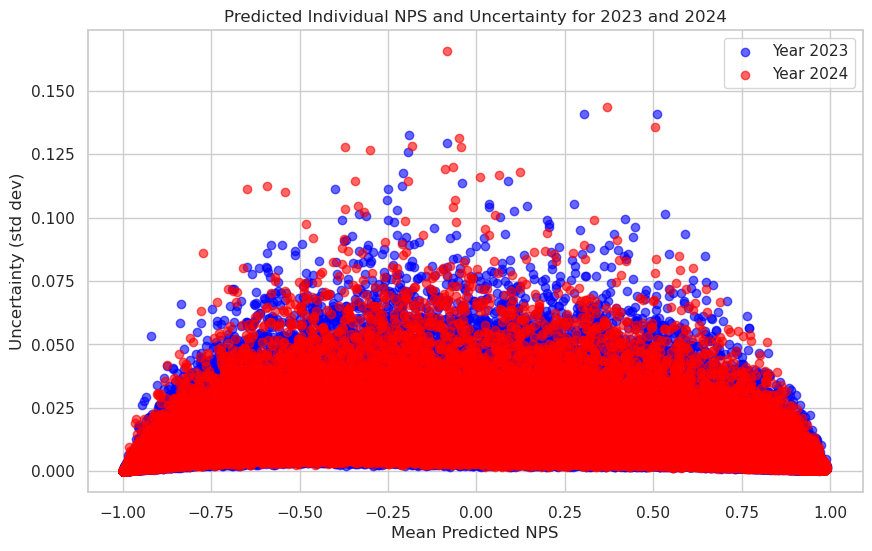

In [22]:
import matplotlib.pyplot as plt
# Filter for years 2023 and 2024
filtered_df = hist_df[(hist_df['year'] == 2023) | (hist_df['year'] == 2024)]

plt.figure(figsize=(10, 6))

# Scatter plot of mean probabilities vs uncertainties, colored by year
colors = {2023: 'blue', 2024: 'red'}
for year in [2023, 2024]:
    subset = filtered_df[filtered_df['year'] == year]
    plt.scatter(subset['mean_proba_nps'], subset['uncertainty_nps'], color=colors[year], label=f'Year {year}', alpha=0.6)

plt.xlabel('Mean Predicted NPS')
plt.ylabel('Uncertainty (std dev)')
plt.title('Predicted Individual NPS and Uncertainty for 2023 and 2024')
plt.legend()
plt.grid(True)
plt.show()


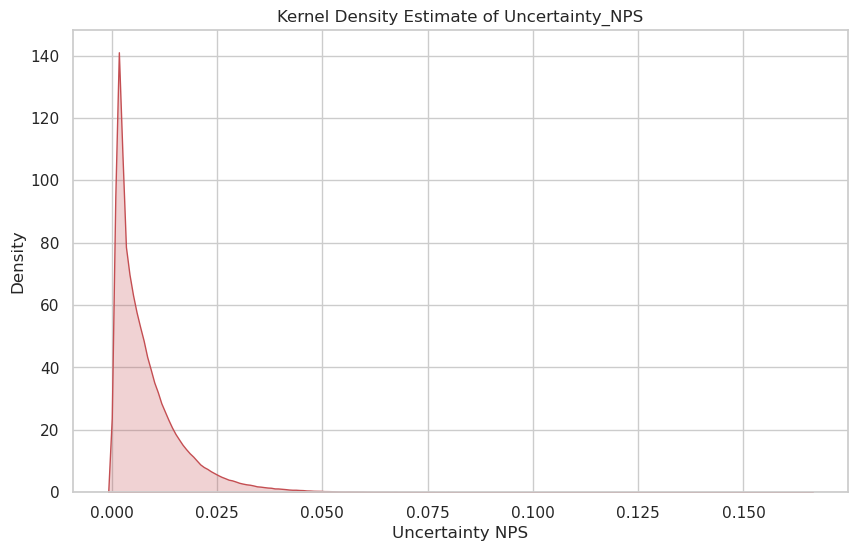

In [23]:
# Set the aesthetic style of the plots
sns.set(style="whitegrid")

# Create the KDE plot
plt.figure(figsize=(10, 6))  # Set the figure size
sns.kdeplot(hist_df['uncertainty_nps'], shade=True, color="r", bw_adjust=0.5)

# Adding labels and title
plt.title('Kernel Density Estimate of Uncertainty_NPS')
plt.xlabel('Uncertainty NPS')
plt.ylabel('Density')

# Display the plot
plt.show()


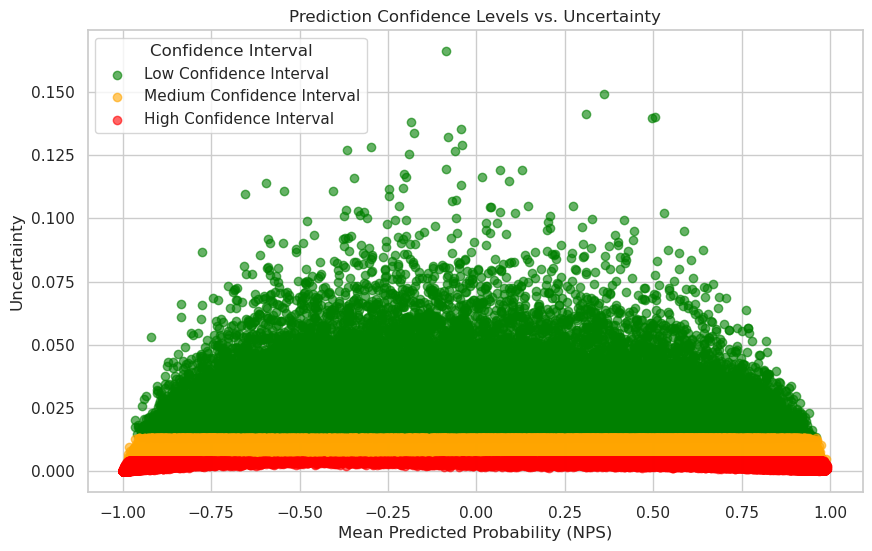

In [65]:
import matplotlib.pyplot as plt
import numpy as np

quants = [0.50, 0.85]

# Assuming 'mean_proba_nps' and 'uncertainty_nps' are columns in filtered_df
# Calculate confidence intervals based on uncertainty
quantiles = filtered_df['uncertainty_nps'].quantile(quants)
filtered_df['confidence_level'] = np.where(filtered_df['uncertainty_nps'] < quantiles[quants[0]], 'High',
                                           np.where(filtered_df['uncertainty_nps'] < quantiles[quants[1]], 'Medium', 'Low'))

# Color mapping for each confidence level
color_map = {'Low': 'green', 'Medium': 'orange', 'High': 'red'}

# Create the scatter plot
plt.figure(figsize=(10, 6))
for level, color in color_map.items():
    # Filter data by confidence level
    subset = filtered_df[filtered_df['confidence_level'] == level]
    plt.scatter(subset['mean_proba_nps'], subset['uncertainty_nps'], color=color, label=f'{level} Confidence Interval', alpha=0.6)

plt.title('Prediction Confidence Levels vs. Uncertainty')
plt.xlabel('Mean Predicted Probability (NPS)')
plt.ylabel('Uncertainty')
plt.legend(title='Confidence Interval')
plt.grid(True)
plt.show()


## Random error from sample choosing

In [4]:
filtered_df=pd.read_csv('predictions (10).csv')

In [8]:
filtered_df

,model_version,respondent_id,date_flight_local,otp15_takeoff,ticket_price,load_factor,pun_100_punctuality,bkg_200_journey_preparation,pfl_100_checkin,pfl_200_security,pfl_300_lounge,pfl_500_boarding,ifl_300_cabin,ifl_200_flight_crew_annoucements,ifl_600_wifi,ifl_500_ife,ifl_400_food_drink,ifl_100_cabin_crew,arr_100_arrivals,con_100_connections,loy_200_loyalty_programme,img_310_ease_contact_phone,ticket_price_nps,load_factor_nps,pun_100_punctuality_nps,bkg_200_journey_preparation_nps,pfl_100_checkin_nps,pfl_200_security_nps,pfl_300_lounge_nps,pfl_500_boarding_nps,ifl_300_cabin_nps,ifl_200_flight_crew_annoucements_nps,ifl_600_wifi_nps,ifl_500_ife_nps,ifl_400_food_drink_nps,ifl_100_cabin_crew_nps,arr_100_arrivals_nps,con_100_connections_nps,loy_200_loyalty_programme_nps,img_310_ease_contact_phone_nps,base_prob_nps,out_prob_nps,uncertainty_nps,insert_date_ci
0,2024-04-12,65792104,2024-03-29,0,30.320,0.879,10.000,10.000,10.000,10.000,NaN,10.000,10.000,10.000,NaN,NaN,NaN,10.000,10.000,NaN,7.000,NaN,0.043,0.000,0.100,0.080,0.058,0.000,-0.001,0.066,0.080,0.001,-0.002,0.002,0.002,0.070,0.058,0.015,-0.024,0.005,0.418,0.971,0.001,2024-04-12
1,2024-04-12,65768624,2024-03-29,0,45.410,0.948,9.000,9.000,9.000,9.000,NaN,8.000,7.000,9.000,NaN,NaN,NaN,9.000,9.000,NaN,8.000,NaN,0.042,-0.007,0.081,0.087,0.067,0.001,-0.001,-0.029,-0.127,0.004,0.001,0.003,0.006,0.069,0.077,0.023,0.026,-0.005,0.418,0.735,0.001,2024-04-12
2,2024-04-12,65935284,2024-04-04,0,381.990,0.870,10.000,10.000,10.000,10.000,NaN,10.000,10.000,10.000,10.000,10.000,10.000,10.000,10.000,10.000,NaN,NaN,-0.023,0.002,0.086,0.077,0.049,0.003,-0.002,0.058,0.081,-0.000,0.021,0.004,0.083,0.076,0.059,-0.006,-0.014,0.009,0.418,0.979,0.001,2024-04-12
3,2024-04-12,65889258,2024-04-03,0,64.560,0.754,9.000,7.000,9.000,7.000,NaN,8.000,10.000,10.000,7.000,NaN,9.000,10.000,9.000,9.000,NaN,NaN,0.015,0.015,0.070,-0.097,0.063,0.001,-0.003,-0.044,0.117,-0.007,0.007,0.002,0.067,0.124,0.077,-0.027,-0.032,0.008,0.418,0.775,0.001,2024-04-12
4,2024-04-12,65935321,2024-04-04,1,209.740,0.810,1.000,4.000,3.000,10.000,NaN,10.000,9.000,4.000,NaN,7.000,3.000,7.000,5.000,NaN,NaN,NaN,-0.005,0.007,-0.603,-0.188,-0.252,-0.015,-0.005,0.122,0.126,-0.003,0.003,-0.014,-0.155,-0.089,-0.209,0.029,-0.065,0.005,0.418,-0.894,-0.002,2024-04-12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7530,2024-04-12,65888751,2024-04-02,1,536.880,0.993,1.000,4.000,8.000,8.000,NaN,2.000,2.000,6.000,4.000,7.000,3.000,3.000,8.000,5.000,NaN,NaN,-0.035,-0.008,-0.338,-0.107,0.032,-0.012,-0.001,-0.158,-0.279,0.004,0.003,-0.011,-0.108,-0.334,0.063,-0.048,-0.054,0.002,0.418,-0.972,-0.002,2024-04-12
7531,2024-04-12,65768798,2024-03-29,0,25.680,0.580,10.000,NaN,7.000,7.000,NaN,10.000,9.000,10.000,NaN,NaN,NaN,10.000,9.000,NaN,6.000,NaN,0.055,0.023,0.159,-0.043,-0.108,-0.005,-0.001,0.092,0.097,-0.003,-0.002,0.002,0.011,0.112,0.060,0.021,-0.051,0.010,0.418,0.845,0.001,2024-04-12
7532,2024-04-12,65934653,2024-04-05,0,29.410,0.589,7.000,9.000,9.000,8.000,NaN,10.000,10.000,10.000,NaN,NaN,9.000,10.000,8.000,NaN,NaN,NaN,0.027,0.017,-0.150,0.084,0.066,-0.003,-0.002,0.102,0.116,-0.010,-0.001,-0.001,0.063,0.124,-0.107,0.032,-0.031,0.005,0.418,0.750,0.001,2024-04-12
7533,2024-04-12,66040005,2024-04-07,0,387.100,0.830,8.000,0.000,0.000,8.000,NaN,0.000,10.000,10.000,10.000,10.000,10.000,4.000,10.000,10.000,NaN,NaN,-0.011,0.008,-0.033,-0.372,-0.360,-0.013,-0.006,-0.420,0.111,-0.021,0.012,0.015,0.093,-0.405,0.124,-0.025,-0.058,0.021,0.418,-0.923,-0.003,2024-04-12


In [7]:
import numpy as np
import pandas as pd

def sample_uncertainties(data, n_samples=100, sample_size=1):
    results = []
    np.random.seed(42)  # For reproducibility

    for _ in range(n_samples):
        # Randomly select samples
        sample = data.sample(n=sample_size)
        mean_prediction = sample['out_prob_nps'].mean()

        # Model uncertainty (quadratic sum of uncertainties in the sample)
        model_uncertainty = sample['uncertainty_nps'].mean()
        
        # Sampling uncertainty (SEM)
        sem = sample['mean_proba_nps'].std(ddof=1) / np.sqrt(sample_size)
        
        # Total uncertainty (quadratic sum of model uncertainty and SEM)
        total_uncertainty = model_uncertainty+ sem
        
        results.append((mean_prediction, model_uncertainty, sem, total_uncertainty))

    results_df = pd.DataFrame(results, columns=['mean_prediction', 'model_uncertainty', 'SEM', 'total_uncertainty'])
    return results_df

# Use the function on your filtered DataFrame
results_df = sample_uncertainties(filtered_df)

# Display the first few results
print(results_df.head())


   mean_prediction  model_uncertainty  SEM  total_uncertainty
0            0.628              0.002  NaN                NaN
1            0.853              0.007  NaN                NaN
2            0.862              0.001  NaN                NaN
3            0.842              0.000  NaN                NaN
4            0.889              0.000  NaN                NaN


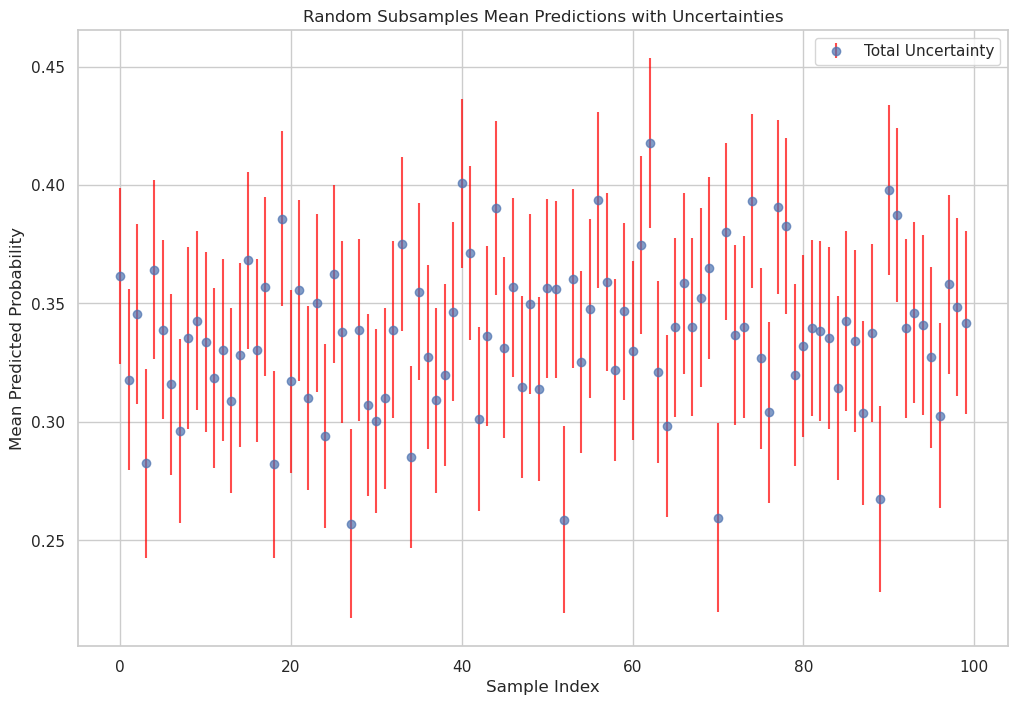

In [67]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
plt.errorbar(x=results_df.index, y=results_df['mean_prediction'], yerr=results_df['total_uncertainty'], fmt='o', label='Total Uncertainty', ecolor='red', alpha=0.7)
# plt.errorbar(x=results_df.index, y=results_df['mean_prediction'], yerr=results_df['model_uncertainty'], fmt='o', label='Model Uncertainty', ecolor='blue', alpha=0.5)
# plt.errorbar(x=results_df.index, y=results_df['mean_prediction'], yerr=results_df['SEM'], fmt='o', label='SEM', ecolor='green', alpha=0.3)

plt.title('Random Subsamples Mean Predictions with Uncertainties')
plt.xlabel('Sample Index')
plt.ylabel('Mean Predicted Probability')
plt.legend()
plt.grid(True)
plt.show()


## For different sample sizes

In [9]:
filtered_df=pd.read_csv('predictions (11).csv')

In [11]:
filtered_df

,model_version,respondent_id,date_flight_local,otp15_takeoff,ticket_price,load_factor,pun_100_punctuality,bkg_200_journey_preparation,pfl_100_checkin,pfl_200_security,pfl_300_lounge,pfl_500_boarding,ifl_300_cabin,ifl_200_flight_crew_annoucements,ifl_600_wifi,ifl_500_ife,ifl_400_food_drink,ifl_100_cabin_crew,arr_100_arrivals,con_100_connections,loy_200_loyalty_programme,img_310_ease_contact_phone,ticket_price_nps,load_factor_nps,pun_100_punctuality_nps,bkg_200_journey_preparation_nps,pfl_100_checkin_nps,pfl_200_security_nps,pfl_300_lounge_nps,pfl_500_boarding_nps,ifl_300_cabin_nps,ifl_200_flight_crew_annoucements_nps,ifl_600_wifi_nps,ifl_500_ife_nps,ifl_400_food_drink_nps,ifl_100_cabin_crew_nps,arr_100_arrivals_nps,con_100_connections_nps,loy_200_loyalty_programme_nps,img_310_ease_contact_phone_nps,base_prob_nps,out_prob_nps,uncertainty_nps,insert_date_ci
0,2024-04-12,65792104,2024-03-29,0,30.320,0.879,10.000,10.000,10.000,10.000,NaN,10.000,10.000,10.000,NaN,NaN,NaN,10.000,10.000,NaN,7.000,NaN,0.043,0.000,0.100,0.080,0.058,0.000,-0.001,0.066,0.080,0.001,-0.002,0.002,0.002,0.070,0.058,0.015,-0.024,0.005,0.418,0.971,0.001,2024-04-12
1,2024-04-12,65768624,2024-03-29,0,45.410,0.948,9.000,9.000,9.000,9.000,NaN,8.000,7.000,9.000,NaN,NaN,NaN,9.000,9.000,NaN,8.000,NaN,0.042,-0.007,0.081,0.087,0.067,0.001,-0.001,-0.029,-0.127,0.004,0.001,0.003,0.006,0.069,0.077,0.023,0.026,-0.005,0.418,0.735,0.002,2024-04-12
2,2024-04-12,65935284,2024-04-04,0,381.990,0.870,10.000,10.000,10.000,10.000,NaN,10.000,10.000,10.000,10.000,10.000,10.000,10.000,10.000,10.000,NaN,NaN,-0.023,0.002,0.086,0.077,0.049,0.003,-0.002,0.058,0.081,-0.000,0.021,0.004,0.083,0.076,0.059,-0.006,-0.014,0.009,0.418,0.979,0.002,2024-04-12
3,2024-04-12,65889258,2024-04-03,0,64.560,0.754,9.000,7.000,9.000,7.000,NaN,8.000,10.000,10.000,7.000,NaN,9.000,10.000,9.000,9.000,NaN,NaN,0.015,0.015,0.070,-0.097,0.063,0.001,-0.003,-0.044,0.117,-0.007,0.007,0.002,0.067,0.124,0.077,-0.027,-0.032,0.008,0.418,0.775,0.001,2024-04-12
4,2024-04-12,65935321,2024-04-04,1,209.740,0.810,1.000,4.000,3.000,10.000,NaN,10.000,9.000,4.000,NaN,7.000,3.000,7.000,5.000,NaN,NaN,NaN,-0.005,0.007,-0.603,-0.188,-0.252,-0.015,-0.005,0.122,0.126,-0.003,0.003,-0.014,-0.155,-0.089,-0.209,0.029,-0.065,0.005,0.418,-0.894,0.002,2024-04-12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7530,2024-04-12,65888751,2024-04-02,1,536.880,0.993,1.000,4.000,8.000,8.000,NaN,2.000,2.000,6.000,4.000,7.000,3.000,3.000,8.000,5.000,NaN,NaN,-0.035,-0.008,-0.338,-0.107,0.032,-0.012,-0.001,-0.158,-0.279,0.004,0.003,-0.011,-0.108,-0.334,0.063,-0.048,-0.054,0.002,0.418,-0.972,0.002,2024-04-12
7531,2024-04-12,65768798,2024-03-29,0,25.680,0.580,10.000,NaN,7.000,7.000,NaN,10.000,9.000,10.000,NaN,NaN,NaN,10.000,9.000,NaN,6.000,NaN,0.055,0.023,0.159,-0.043,-0.108,-0.005,-0.001,0.092,0.097,-0.003,-0.002,0.002,0.011,0.112,0.060,0.021,-0.051,0.010,0.418,0.845,0.002,2024-04-12
7532,2024-04-12,65934653,2024-04-05,0,29.410,0.589,7.000,9.000,9.000,8.000,NaN,10.000,10.000,10.000,NaN,NaN,9.000,10.000,8.000,NaN,NaN,NaN,0.027,0.017,-0.150,0.084,0.066,-0.003,-0.002,0.102,0.116,-0.010,-0.001,-0.001,0.063,0.124,-0.107,0.032,-0.031,0.005,0.418,0.750,0.003,2024-04-12
7533,2024-04-12,66040005,2024-04-07,0,387.100,0.830,8.000,0.000,0.000,8.000,NaN,0.000,10.000,10.000,10.000,10.000,10.000,4.000,10.000,10.000,NaN,NaN,-0.011,0.008,-0.033,-0.372,-0.360,-0.013,-0.006,-0.420,0.111,-0.021,0.012,0.015,0.093,-0.405,0.124,-0.025,-0.058,0.021,0.418,-0.923,0.007,2024-04-12


In [12]:
filtered_df = filtered_df.rename(columns={'out_prob_nps': 'mean_proba_nps'})

In [15]:
def calculate_nps(group_df):
    """
    Calculate the weighted Net Promoter Score (NPS) for a group of data.
    
    Parameters:
    - group_df (DataFrame): A pandas DataFrame containing the 'nps_100' column with scores from 0 to 10.
    
    Returns:
    - float: The NPS score, calculated as ((number of promoters - number of detractors) / total respondents) * 100
    """
    # Calculate promoters (scores 9 or 10)
    promoters = group_df[group_df['nps_100'] > 8]['nps_100'].count()
    
    # Calculate detractors (scores 0 to 6)
    detractors = group_df[group_df['nps_100'] <= 6]['nps_100'].count()
    
    # Total number of respondents
    total = group_df['nps_100'].count()
    
    if total > 0:  # Check to avoid division by zero
        # Calculate NPS
        nps_score = ((promoters - detractors) / total)
        return nps_score
    else:
        return None  # Return None or suitable value if no respondents are there


def sample_uncertainties_by_size(data, sample_sizes, n_iterations=1):
    results = []

    for size in sample_sizes:
        for _ in range(n_iterations):
            # Randomly select samples
            sample = data.sample(n=size)
            mean_prediction = sample['mean_proba_nps'].mean()

            # Model uncertainty (quadratic sum of uncertainties in the sample)
            model_uncertainty = sample['uncertainty_nps'].mean()

            # Sampling uncertainty (SEM)
            sem = sample['mean_proba_nps'].std(ddof=1) / np.sqrt(size)

            # Total uncertainty (quadratic sum of model uncertainty and SEM)
            total_uncertainty = np.sqrt(model_uncertainty**2 + sem**2)

            results.append((size, mean_prediction, model_uncertainty, sem, total_uncertainty))

    results_df = pd.DataFrame(results, columns=['sample_size', 'mean_prediction', 'model_uncertainty', 'SEM', 'total_uncertainty'])
    return results_df

# Sample sizes from 100 to 3000 in steps of 50
sample_sizes = np.arange(100, 3001, 50)
results_df = sample_uncertainties_by_size(filtered_df, sample_sizes)


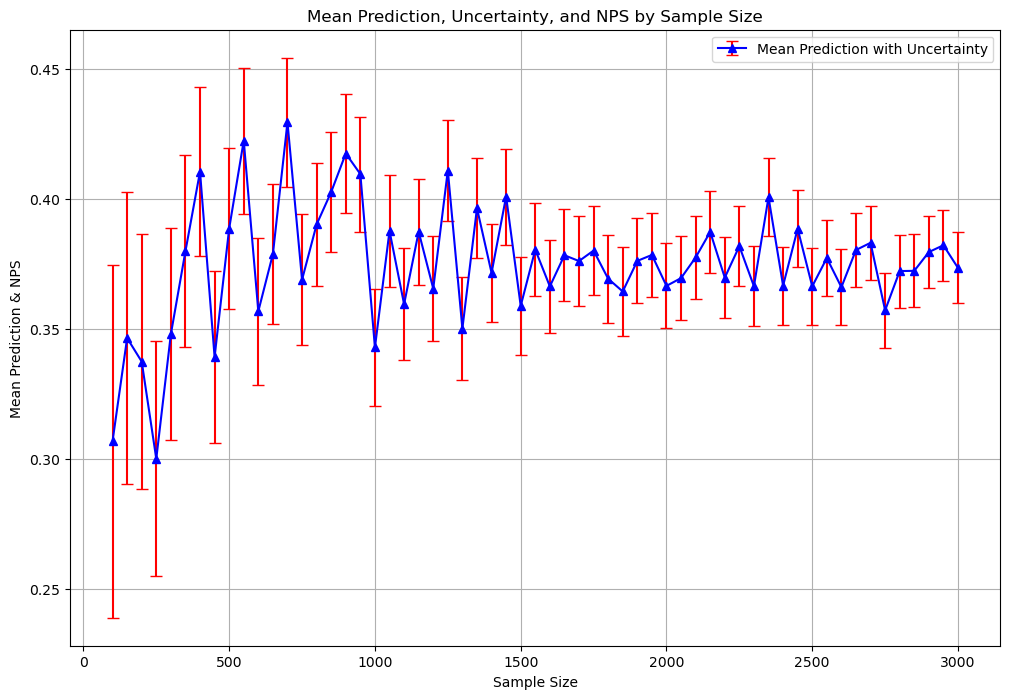

In [16]:
import matplotlib.pyplot as plt

# Assuming 'results_df' contains 'sample_size', 'mean_prediction', 'total_uncertainty', and now 'NPS' for each sample size
# Group data by sample size to calculate mean of predictions, total uncertainties, and NPS
grouped = results_df.groupby('sample_size').agg({
    # 'NPS': 'mean',  # Assuming the NPS is already computed and included in results_df
    'mean_prediction': 'mean',
    'total_uncertainty': 'mean'
}).reset_index()

# Create the plot
plt.figure(figsize=(12, 8))

# Plot mean prediction with uncertainty
plt.errorbar(grouped['sample_size'], grouped['mean_prediction'], yerr=grouped['total_uncertainty'], fmt='o', ecolor='red', capsize=4, linestyle='-', marker='^', color='blue', label='Mean Prediction with Uncertainty')

# Plot NPS on the same axis
# plt.plot(grouped['sample_size'], grouped['NPS'], color='green', marker='s', linestyle='', label='NPS')

# Titles and labels
plt.title('Mean Prediction, Uncertainty, and NPS by Sample Size')
plt.xlabel('Sample Size')
plt.ylabel('Mean Prediction & NPS')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

In [70]:
grouped['total_uncertainty'].min()

0.014533720395912456

In [71]:
grouped['total_uncertainty'].max()

0.06980078537262135

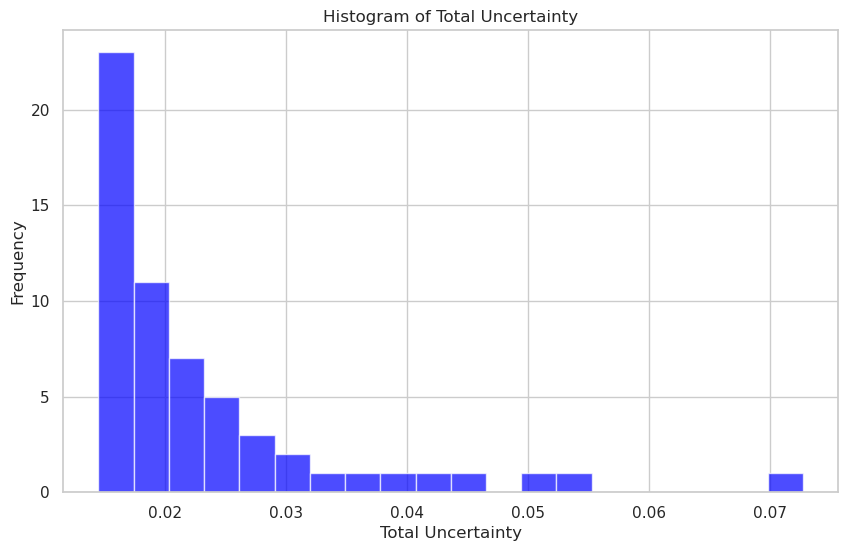

In [75]:
results_df['rel_uncertainty']=results_df['total_uncertainty']/results_df['mean_prediction']
# Create the histogram plot
plt.figure(figsize=(10, 6))
plt.hist(results_df['total_uncertainty'].dropna(), bins=20, color='blue', alpha=0.7)  # Using dropna() to ensure there are no NaN values
plt.title('Histogram of Total Uncertainty')
plt.xlabel('Total Uncertainty')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()
